# Outline
This tutorial demonstrates various data cleaning stages on a sample astronomical dataset.

1) Setting up the environment
2) Downloading and importing the dataset
3) Inspect and visualize the dataset content
4) Run some consistency checks on the dataset
5) Detect and handle missing data values
6) Detect outliers

The original dataset is the `Stellar Classification Dataset`, available here:

- SDSS DR17: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17. 
- SDSS DR19: https://www.kaggle.com/datasets/randelmaglaya/sdss-dr19-2025/data

For this tutorial, however, we will use a modified "dirtier" version of the dataset, in which we artificially added corrupted, missing data, and outliers/anomalies.

# Configuring the environment

## Module installation
We’ll begin by installing the necessary Python modules for this tutorial.

In [3]:
import os

# - Install modules from requirements.txt if present
if os.path.isfile("requirements.txt"):
  print("Installing modules from local requirements.txt file ...")
  %pip install -q -r requirements.txt
else:
  print("Installing modules ...")

  %pip install -q gdown                                
  %pip install -q matplotlib seaborn[stats]                     
  %pip install -q pandas scikit-learn umap-learn[plot]
  
  # - Create requirements file
  %pip freeze > requirements.txt

Installing modules ...
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import modules
Next, we import the essential modules needed throughout the tutorial.

In [38]:
###########################
##   STANDARD MODULES
###########################
import os
from pathlib import Path
import shutil
import gdown
import random
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()

###########################
##   ML MODULES
###########################
import pandas as pd
from pandas import read_csv
from sklearn.feature_selection import VarianceThreshold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import umap, umap.plot
from umap import UMAP

## Set random seeds
Let's define a function to set random numpy seeds to make random generation reproducible.

In [5]:
def set_seed(seed=42):
  """ Set random seed """
  random.seed(seed)
  np.random.seed(seed)

# - Set the seed
set_seed(1)

## Project folders
We create a working directory `rundir` to run the tutorial in.

In [6]:
topdir= os.getcwd()
rundir= os.path.join(topdir, "run-data_cleaning")
path = Path(rundir)
path.mkdir(parents=True, exist_ok=True)

# Dataset
For this tutorial, we will use the [**Stellar Classification Dataset - SDSS DR19**](https://www.kaggle.com/datasets/randelmaglaya/sdss-dr19-2025/data).

This dataset contains **100,000** observations of sources taken by the SDSS (Sloan Digital Sky Survey) in various optical bands. SDSS photometric data are observed through five filters, u, g, r, i, and z. Every observation is described by **17 feature columns** and **1 class column** which identifies it to be either a **star**, **galaxy** or **quasar**.

1) `obj_ID`: Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2) `alpha`: Right Ascension angle (at J2000 epoch)
3) `delta`: Declination angle (at J2000 epoch)
4) `u`: Ultraviolet filter in the photometric system
5) `g`: Green filter in the photometric system
6) `r`: Red filter in the photometric system
7) `i`: Near Infrared filter in the photometric system
8) `z`: Infrared filter in the photometric system
9) `run_ID`: Run Number used to identify the specific scan
10) `rerun_ID`: Rerun Number to specify how the image was processed
11) `cam_col`: Camera column to identify the scanline within the run
12) `field_ID`: Field number to identify each field
13) `spec_obj_ID`: Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14) `class`: object class (galaxy, star or quasar object)
15) `redshift`: redshift value based on the increase in wavelength
16) `plate`: plate ID, identifies each plate in SDSS
17) `MJD`: Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18) `fiber_ID`: fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

## Dataset Download
Next, we download the dataset from Google Drive and unzip it in the main folder.

In [7]:
# - Download dataset
def download_data(fname, url, destdir, force=False):
  """ Download dataset """
  
  # - Download dataset (if not previously downloaded)
  fname_full= os.path.join(destdir, fname)
  if force or not os.path.isfile(fname_full):
    print(f"Downloading data from url {url} ...")
    gdown.download(url, fname, quiet=False)
    print("DONE!")
    
  # - Moving data to destdir
  if os.path.isfile(fname) and os.path.isdir(destdir):
    print(f"Moving data {fname} to dir %s ..." % (destdir))
    shutil.move(fname, fname_full)  

# - Set dataset URL & paths
dataset_name= 'star_classification.csv'
dataset_name_fullpath= os.path.join(rundir, dataset_name)
#dataset_url= 'https://drive.google.com/uc?export=download&id=170VmM5ETBRgY93vD0phuas_6PIgq08u-' # DR17
#dataset_url= 'https://drive.google.com/uc?export=download&id=1RH1v7q2bukXV4BNQhp30EsOdncxgIrwk' # DR19
dataset_url= 'https://drive.google.com/uc?export=download&id=1rFoh30_zNdDJJ_tdnEdVpepbATOpvx5D' # DR19 dirty

# - Download dataset
download_data(dataset_name, dataset_url, rundir, force=True)

Downloading...
From: https://drive.google.com/uc?export=download&id=1rFoh30_zNdDJJ_tdnEdVpepbATOpvx5D
To: /home/riggi/Analysis/MLProjects/INAF-USC-C-AI/school2026/notebooks/star_classification.csv
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15.7M/15.7M [00:01<00:00, 8.12MB/s]

DONE!
Moving data star_classification.csv to dir /home/riggi/Analysis/MLProjects/INAF-USC-C-AI/school2026/notebooks/run-data_cleaning ...


## Dataset load
Let's load the downloaded dataset as a Pandas data frame.

In [8]:
print(f"Loading data from file {dataset_name_fullpath} ...")
try:
  df= pd.read_csv(dataset_name_fullpath, sep=',')
  print(df)
  #print(df.head())
  #print(df.tail())
except UnicodeDecodeError:
  print(f"Unicode decoding error when loading data file {dataset_name_fullpath}!")

Loading data from file /home/riggi/Analysis/MLProjects/INAF-USC-C-AI/school2026/notebooks/run-data_cleaning/star_classification.csv ...
                     obj_ID       alpha      delta         u         g  \
0       1237652947459637379   17.941809  -9.816818      -inf  17.43624   
1       1237671123217940946  122.127448   7.336519  18.55875  16.56873   
2       1237672026783416538  336.686095  39.020594  15.23208  15.55459   
3       1237663542064119850  311.369182  -1.009367  18.65634  17.48205   
4       1237648702973542435  199.516504  -1.123175  18.00832  16.83256   
...                     ...         ...        ...       ...       ...   
101995  1237655126082846840  184.088675   5.459447  19.31630  17.96200   
101996  1237664853114159283  232.163943  27.435908  19.40644  18.14540   
101997  1237658492286599185  196.790855   9.552958  18.82735  18.42521   
101998  1237657595152171182  127.857481  40.956219       NaN  14.48068   
101999  1237679502705492124  353.260324  18.903515

Let's inspect the loaded data frame.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102000 entries, 0 to 101999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       102000 non-null  int64  
 1   alpha        102000 non-null  float64
 2   delta        102000 non-null  float64
 3   u            100067 non-null  float64
 4   g            100473 non-null  float64
 5   r            101179 non-null  float64
 6   i            101183 non-null  float64
 7   z            100478 non-null  float64
 8   run_ID       102000 non-null  int64  
 9   rerun_ID     102000 non-null  int64  
 10  cam_col      102000 non-null  int64  
 11  field_ID     102000 non-null  int64  
 12  spec_obj_ID  102000 non-null  uint64 
 13  class        102000 non-null  object 
 14  redshift     102000 non-null  float64
 15  plate        102000 non-null  int64  
 16  MJD          102000 non-null  int64  
 17  fiber_ID     102000 non-null  int64  
dtypes: float64(8), int64(8),

In [19]:
df.describe()

/home/riggi/Software/venvs/usc-c-ai-school-2026/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/riggi/Software/venvs/usc-c-ai-school-2026/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/riggi/Software/venvs/usc-c-ai-school-2026/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/riggi/Software/venvs/usc-c-ai-school-2026/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/riggi/Software/venvs/usc-c-ai-school-2026/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in 

obj_ID          alpha          delta             u             g  \
count  1.020000e+05  102000.000000  102000.000000  1.000670e+05  1.004730e+05   
mean   1.237663e+18     177.063802      24.989593           NaN           NaN   
std    7.277021e+12      78.292749      20.562426           NaN           NaN   
min    1.237646e+18       0.011306     -19.306395          -inf          -inf   
25%    1.237658e+18     136.008447       6.657628  1.821624e+01  1.685172e+01   
50%    1.237662e+18     179.945866      23.851388  1.887664e+01  1.751741e+01   
75%    1.237667e+18     224.281339      40.285868  1.927474e+01  1.805712e+01   
max    1.237681e+18     359.999615      84.490494           inf           inf   

                  r             i             z         run_ID  rerun_ID  \
count  1.011790e+05  1.011830e+05  1.004780e+05  102000.000000  102000.0   
mean            inf           inf           NaN    3981.321804     301.0   
std             NaN           NaN           NaN    1694.314007       0.0   
min    9.823509e+00  9.337089e+00          -inf     109.000000     301.0   
25%    1.619863e+01  1.586763e+01  1.562012e+01    2826.000000     301.0   
50%    1.689665e+01  1.660286e+01  1.642687e+01    3903.000000     301.0   
75%    1.759093e+01  1.734983e+01  1.723462e+01    5061.000000     301.0   
max             inf           inf           inf    8162.000000     301.0   

             cam_col       field_ID   spec_obj_ID       redshift  \
count  102000.000000  102000.000000  1.020000e+05  102000.000000   
mean        3.286676     186.076657  2.917863e+18       0.170501   
std         1.626186     140.984758  2.503074e+18       0.437256   
min         1.000000      11.000000  2.994897e+17      -0.004136   
25%         2.000000      85.000000  1.333178e+18       0.000003   
50%         3.000000     151.000000  2.341980e+18       0.046372   
75%         5.000000     247.000000  3.275280e+18       0.095634   
max         6.000000     982.000000  1.412681e+19       7.011245   

               plate            MJD       fiber_ID  
count  102000.000000  102000.000000  102000.000000  
mean     2591.499275   53914.475990     342.084794  
std      2223.162147    1551.860652     216.731915  
min       266.000000   51608.000000       1.000000  
25%      1184.000000   52733.000000     160.000000  
50%      2080.000000   53726.000000     329.000000  
75%      2909.000000   54585.000000     502.000000  
max     12547.000000   58932.000000    1000.000000

We remove the columns we are not interested in for this tutorial, leaving only band fluxes, redshift and class information.

In [20]:
columns_to_be_removed= ["alpha", "delta", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "plate", "MJD", "fiber_ID"]
df.drop(columns_to_be_removed, inplace=True, axis=1)
df.describe()

/home/riggi/Software/venvs/usc-c-ai-school-2026/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/riggi/Software/venvs/usc-c-ai-school-2026/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/riggi/Software/venvs/usc-c-ai-school-2026/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/riggi/Software/venvs/usc-c-ai-school-2026/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/riggi/Software/venvs/usc-c-ai-school-2026/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in 

obj_ID             u             g             r             i  \
count  1.020000e+05  1.000670e+05  1.004730e+05  1.011790e+05  1.011830e+05   
mean   1.237663e+18           NaN           NaN           inf           inf   
std    7.277021e+12           NaN           NaN           NaN           NaN   
min    1.237646e+18          -inf          -inf  9.823509e+00  9.337089e+00   
25%    1.237658e+18  1.821624e+01  1.685172e+01  1.619863e+01  1.586763e+01   
50%    1.237662e+18  1.887664e+01  1.751741e+01  1.689665e+01  1.660286e+01   
75%    1.237667e+18  1.927474e+01  1.805712e+01  1.759093e+01  1.734983e+01   
max    1.237681e+18           inf           inf           inf           inf   

                  z       redshift  
count  1.004780e+05  102000.000000  
mean            NaN       0.170501  
std             NaN       0.437256  
min            -inf      -0.004136  
25%    1.562012e+01       0.000003  
50%    1.642687e+01       0.046372  
75%    1.723462e+01       0.095634  
max             inf       7.011245

# Data Integrity Check
Let's run first some integrity check on the loaded data frame.

## Checking for nans/inf
Let's see if the loaded data frame contains any missing values (empty column value) or +-inf numerical values.

In [21]:
def dump_nan_counts(df):
  total_nan_count = df.isnull().sum().sum()
  print("--> Total NaN count:", total_nan_count)
  column_nan_count = df.isnull().sum()
  print("--> NaN count per column")
  print(column_nan_count)

dump_nan_counts(df)

--> Total NaN count: 6620
--> NaN count per column
obj_ID         0
u           1933
g           1527
r            821
i            817
z           1522
class          0
redshift       0
dtype: int64


In [22]:
def dump_inf_counts(df):
  is_infinite = df.isin([np.inf, -np.inf])
  counts_dict= is_infinite.stack().value_counts().to_dict()
  total_inf_count= 0 if True not in counts_dict else counts_dict[True]
  print("--> Total Inf count:", total_inf_count)

  print("--> Inf count per column:")
  for col in is_infinite.columns:
    counts_dict= is_infinite[col].value_counts().to_dict()
    counts_inf= 0 if True not in counts_dict else counts_dict[True]
    print(f"{col}: {counts_inf}")
    
dump_inf_counts(df)

--> Total Inf count: 1642
--> Inf count per column:
obj_ID: 0
u: 407
g: 302
r: 315
i: 314
z: 304
class: 0
redshift: 0


Let's convert the inf values into NaNs from the rest of the tutorial.

In [23]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
dump_nan_counts(df)

--> Total NaN count: 8262
--> NaN count per column
obj_ID         0
u           2340
g           1829
r           1136
i           1131
z           1826
class          0
redshift       0
dtype: int64


## Checking for duplicates
Let's find if the dataset has duplicated rows. We consider all columns for the search (e.g. `subset=None`).

In [24]:
n_dupl= df.duplicated(keep='first', subset=None).sum()
print(f"Dataset has {n_dupl} duplicated rows")

Dataset has 2000 duplicated rows


We can remove duplicated rows from the current data frame, leaving only the first occurrence with the following method.

In [25]:
df.drop_duplicates(keep='first',subset=None, inplace=True)
n_dupl= df.duplicated(keep='first', subset=None).sum()
print(f"[AFTER DUPLICATE REMOVAL] Dataset has {n_dupl} duplicated rows")

[AFTER DUPLICATE REMOVAL] Dataset has 0 duplicated rows


## Checking for unique values
Let's inspect the value "diversity" within each column. 
- Some columns (e.g. `obj_ID`), suitable to be used as frame index, are expected to contain unique values, so the presence of non unique values is likely indicating typos. 
- Low counts in categorical columns (e.g. `class`) are usually fine 
- High counts in numerical quantitative columns (e.g. flux `u`, `g`, `r`) is likely as issue.

In [26]:
n_unique= df.nunique(dropna=False)
num_rows = len(df.index)
print(n_unique/num_rows*100)

obj_ID      100.000
u            77.950
g            84.082
r            86.485
i            87.114
z            87.497
class         0.012
redshift     93.939
dtype: float64


Let's print the fraction of unique values for each column.

In [27]:
print("Unique value counts")
for col in df.columns:
  counts= df[col].value_counts(normalize=True, dropna=False)*100
  print(f"--> {col}")
  print(counts)

Unique value counts
--> obj_ID
obj_ID
1237663277926252765    0.001
1237668494707392644    0.001
1237666339188572196    0.001
1237648720175562763    0.001
1237649961918267493    0.001
                       ...  
1237648702973542435    0.001
1237663542064119850    0.001
1237672026783416538    0.001
1237671123217940946    0.001
1237652947459637379    0.001
Name: proportion, Length: 100000, dtype: float64
--> u
u
NaN         2.283
19.31901    0.006
19.49681    0.006
19.34645    0.006
19.54784    0.006
            ...  
19.12331    0.001
17.35995    0.001
19.53010    0.001
18.48188    0.001
17.58997    0.001
Name: proportion, Length: 77950, dtype: float64
--> g
g
NaN         1.798
18.02139    0.005
17.68875    0.005
17.53222    0.005
18.64013    0.005
            ...  
16.65083    0.001
18.01578    0.001
19.12796    0.001
17.92146    0.001
18.04298    0.001
Name: proportion, Length: 84082, dtype: float64
--> r
r
NaN          1.113
9.823509     0.100
17.676400    0.005
17.186940    0.005
17

## Detecting misannotations
Let's inspect the dataset `class` column to count how many instances we have per each class, and find if we have potential issues with the class label annotation.

In [28]:
n_instances_class= df['class'].value_counts(dropna=True)
print(n_instances_class)

class
GALAXY     51247
STAR       37583
QSO        10428
galaxy       130
 GALAXY      125
GALAXY       111
 STAR         99
star          98
STAR          84
QSO           36
 QSO          31
qso           28
Name: count, dtype: int64


As can be seen, there are a few misannotations present in the `class` column. These are fundamentally of two types:

- leading/trailing blank spaces
- lowercase vs uppercase

Let's fix that and check.

In [29]:
df['class']= df['class'].str.strip().str.upper()

n_instances_class= df['class'].value_counts(dropna=True)
print(n_instances_class)

class
GALAXY    51613
STAR      37864
QSO       10523
Name: count, dtype: int64


# Visual analysis
Let's visualize the distribution and correlation of some variables. As we haven't yet handled the missing data, we will limit to plot the complete data, replacing missing values with a fixed value (-1). 
For better visibility, we also log transform the data.

In [30]:
# - Log transform data
df_transf= df[['u','g','r','i','z','redshift','class']].copy() 
df_mins= df_transf.dropna().min().to_dict()
print(df_mins)

for col in df_transf.columns:
  if col=='class':
    continue
  df_transf[col] = df_transf[col].apply(lambda x: np.log(x - df_mins[col] + 1) if np.isfinite(x) else -1)  

df_transf_mins= df_transf.dropna().min().to_dict()
print(df_transf_mins)

{'u': 10.61181, 'g': 9.668339, 'r': 9.823508969, 'i': 9.337089131, 'z': 8.947795, 'redshift': -0.004136078, 'class': 'GALAXY'}
{'u': -1.0, 'g': -1.0, 'r': -1.0, 'i': -1.0, 'z': -1.0, 'redshift': 0.0, 'class': 'GALAXY'}


## Class distribution

Below, we plot the distribution of source classes (column `class`), after having fixed the annotations.

/tmp/ipykernel_13470/2511922769.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


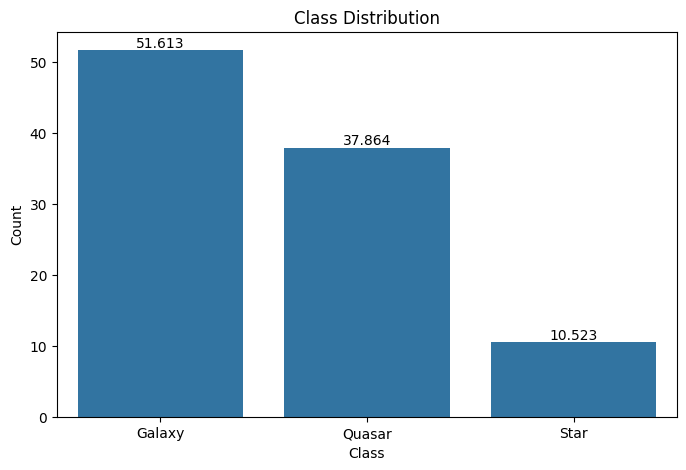

In [39]:
def plot_class_counts(df, normalize=True):
  """ Plot the class count distribution """
  plt.figure(figsize=(8, 5))
  stat= "percent" if normalize else "count"
  ax = sns.countplot(x=df['class'], stat=stat)

  labels = ["Galaxy", "Quasar", "Star"]
  ax.set_xticklabels(labels)

  # Add labels on top of bars
  for container in ax.containers:
    ax.bar_label(container)

  plt.title("Class Distribution")
  plt.xlabel("Class")
  plt.ylabel("Count")
  plt.show()

plot_class_counts(df_transf, normalize=True)

## Redshift distribution
Below, we plot the redshift distribution per each class.

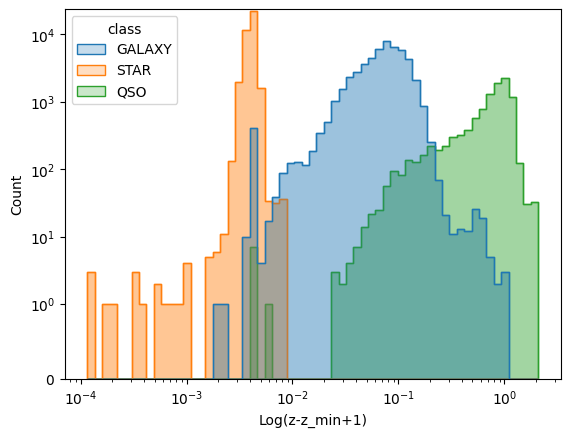

In [45]:
# - Plot redshift
ax= sns.histplot(data=df_transf, x='redshift', hue='class', element="step",
             stat='count', fill=True, binwidth=0.07, log_scale=(True,False))
plt.xlabel("Log(z-z_min+1)")
ax.set_yscale("symlog", linthresh=1) # 0..1 is linear, above is ~log
ax.set_ylim(0, None)
plt.show()

## Band flux distribution
Below, we plot the band flux distribution per each class.

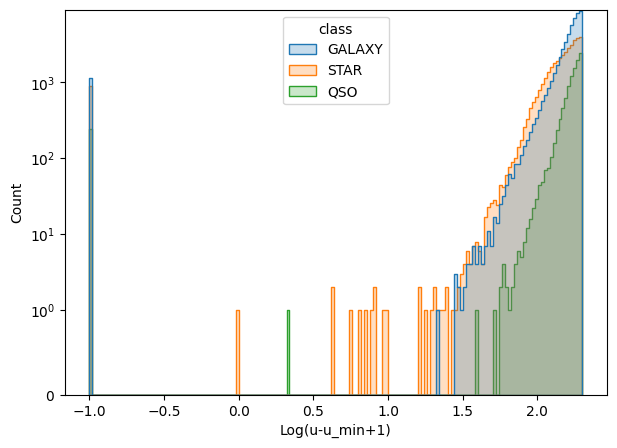

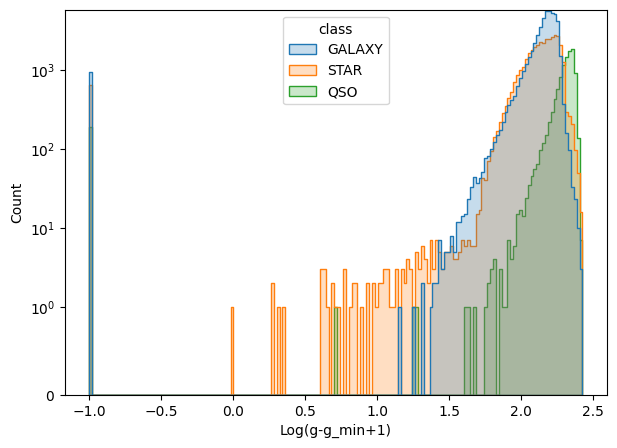

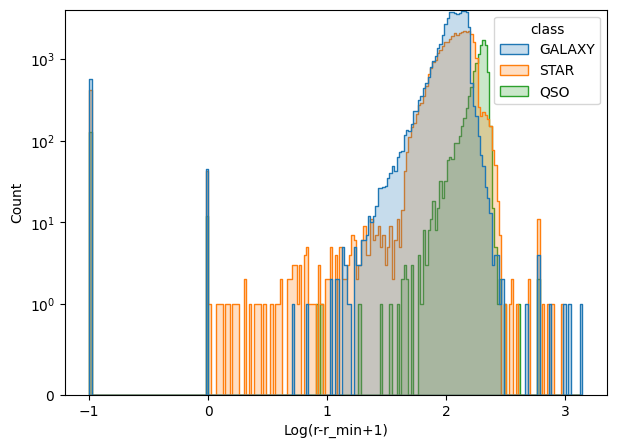

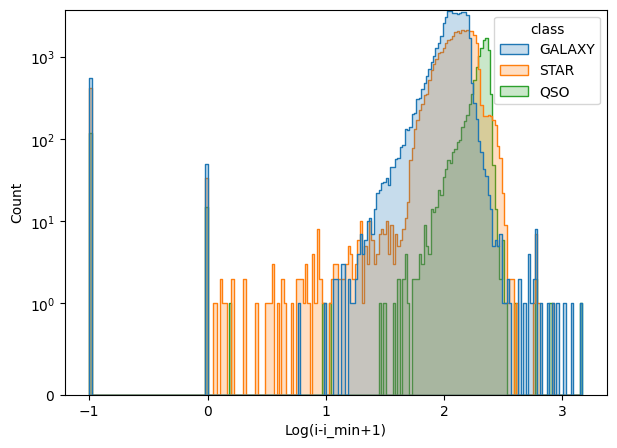

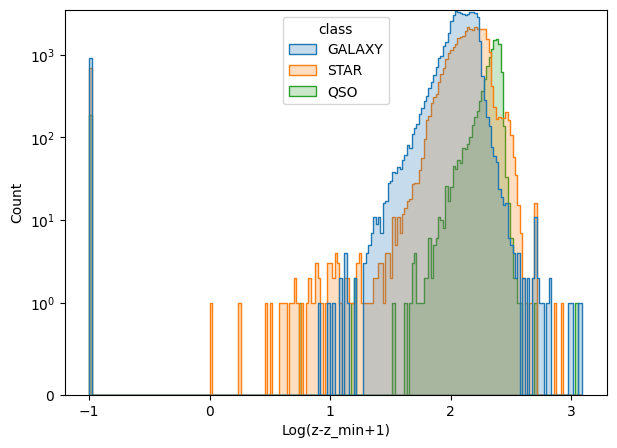

In [46]:
# - Plot flux vars
cols_flux = ['u','g','r','i','z']
cols= ['u','g','r','i','z','redshift']
for col in cols_flux:
  plt.figure(figsize=(7, 5))  
  ax= sns.histplot(data=df_transf, x=col, hue='class', element="step",
             stat='count', fill=True, binwidth=0.02, log_scale=(False,False))
  xlabel = "Log({var}-{var}_min+1)".format(var=col)  
  plt.xlabel(xlabel)
  ax.set_yscale("symlog", linthresh=1) # 0..1 is linear, above is ~log
  ax.set_ylim(0, None)
  plt.show()

## Variable scatter plots
Let's visualize the variable (band flux, redshift) correlations with paired scatter plots.

In [47]:
df_transf.describe(include=[np.number])

u              g              r              i  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        2.122886       2.104195       2.040214       2.067568   
std         0.487531       0.436975       0.360665       0.363618   
min        -1.000000      -1.000000      -1.000000      -1.000000   
25%         2.145375       2.096366       1.994139       2.014916   
50%         2.223727       2.178120       2.085942       2.109596   
75%         2.267265       2.238114       2.169328       2.196909   
max         2.301399       2.425391       3.142711       3.169870   

                   z       redshift  
count  100000.000000  100000.000000  
mean        2.074545       0.121282  
std         0.442953       0.246173  
min        -1.000000       0.000000  
25%         2.031924       0.004131  
50%         2.134048       0.049263  
75%         2.226292       0.095149  
max         3.094185       2.081362

First, we compute the **Pearson**, **Spearman** and **Kendall correlation coefficients** on the transformed observed data, using either Pandas or Scipy implementations.

In [66]:
from scipy import stats
from itertools import combinations

def scipy_corr_matrix(df, method="pearson"):
  """ Helper method to compute correlation coeff & p-values using scipy on input data frame"""  
  cols = df.columns
  n = len(cols)

  corr = pd.DataFrame(np.eye(n), columns=cols, index=cols)
  pval = pd.DataFrame(np.zeros((n,n)), columns=cols, index=cols)

  for col1, col2 in combinations(cols, 2):
    x = df[col1].values
    y = df[col2].values
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    
    if method == "pearson":
      r, p = stats.pearsonr(x, y)
    elif method == "spearman":
      r, p = stats.spearmanr(x, y, nan_policy="omit")
    elif method == "kendall":
      r, p = stats.kendalltau(x, y, nan_policy="omit")
    else:
      raise ValueError("Method must be pearson, spearman, or kendall")

    corr.loc[col1, col2] = r
    corr.loc[col2, col1] = r
    pval.loc[col1, col2] = p
    pval.loc[col2, col1] = p

  return corr, pval

# - Set data
df_transf_nans= df_transf.copy()
df_transf_nans.replace(to_replace=-1, value=np.nan, inplace=True)

# - Compute Pearson coefficient
corr_p_pandas = df_transf_nans[cols].corr(method='pearson')
corr_p, pval_p = scipy_corr_matrix(df_transf_nans[cols], method="pearson")
print("--> Pearson corr coeff (Pandas)")
print(corr_p_pandas)
print("--> Pearson corr coeff (Scipy)")
print(corr_p)

# - Compute Spearman coefficient
corr_s_pandas = df_transf_nans[cols].corr(method='spearman')
corr_s, pval_s = scipy_corr_matrix(df_transf_nans[cols], method="spearman")
print("\n--> Spearman corr coeff (Pandas)")
print(corr_s_pandas)
print("--> Spearman corr coeff (Scipy)")
print(corr_s)

# - Compute Kendall coefficient
corr_k_pandas = df_transf_nans[cols].corr(method='kendall')
corr_k, pval_k = scipy_corr_matrix(df_transf_nans[cols], method="kendall")
print("\n--> Kendall corr coeff (Pandas)")
print(corr_k_pandas)
print("--> Kendall corr coeff (Scipy)")
print(corr_k)

--> Pearson corr coeff (Pandas)
                 u         g         r         i         z  redshift
u         1.000000  0.857186  0.670545  0.602137  0.599309  0.194901
g         0.857186  1.000000  0.884671  0.844985  0.887230  0.411810
r         0.670545  0.884671  1.000000  0.825161  0.883791  0.393831
i         0.602137  0.844985  0.825161  1.000000  0.894637  0.387066
z         0.599309  0.887230  0.883791  0.894637  1.000000  0.417018
redshift  0.194901  0.411810  0.393831  0.387066  0.417018  1.000000
--> Pearson corr coeff (Scipy)
                 u         g         r         i         z  redshift
u         1.000000  0.857186  0.670545  0.602137  0.599309  0.194901
g         0.857186  1.000000  0.884671  0.844985  0.887230  0.411810
r         0.670545  0.884671  1.000000  0.825161  0.883791  0.393831
i         0.602137  0.844985  0.825161  1.000000  0.894637  0.387066
z         0.599309  0.887230  0.883791  0.894637  1.000000  0.417018
redshift  0.194901  0.411810  0.393831  

Below, we display variable scatter plots of transformed observed data (NaNs removed). We also display the correlation coefficients computed above in the upper off-diagonal panels. Variable distributions are displayed in the diagonal panels.

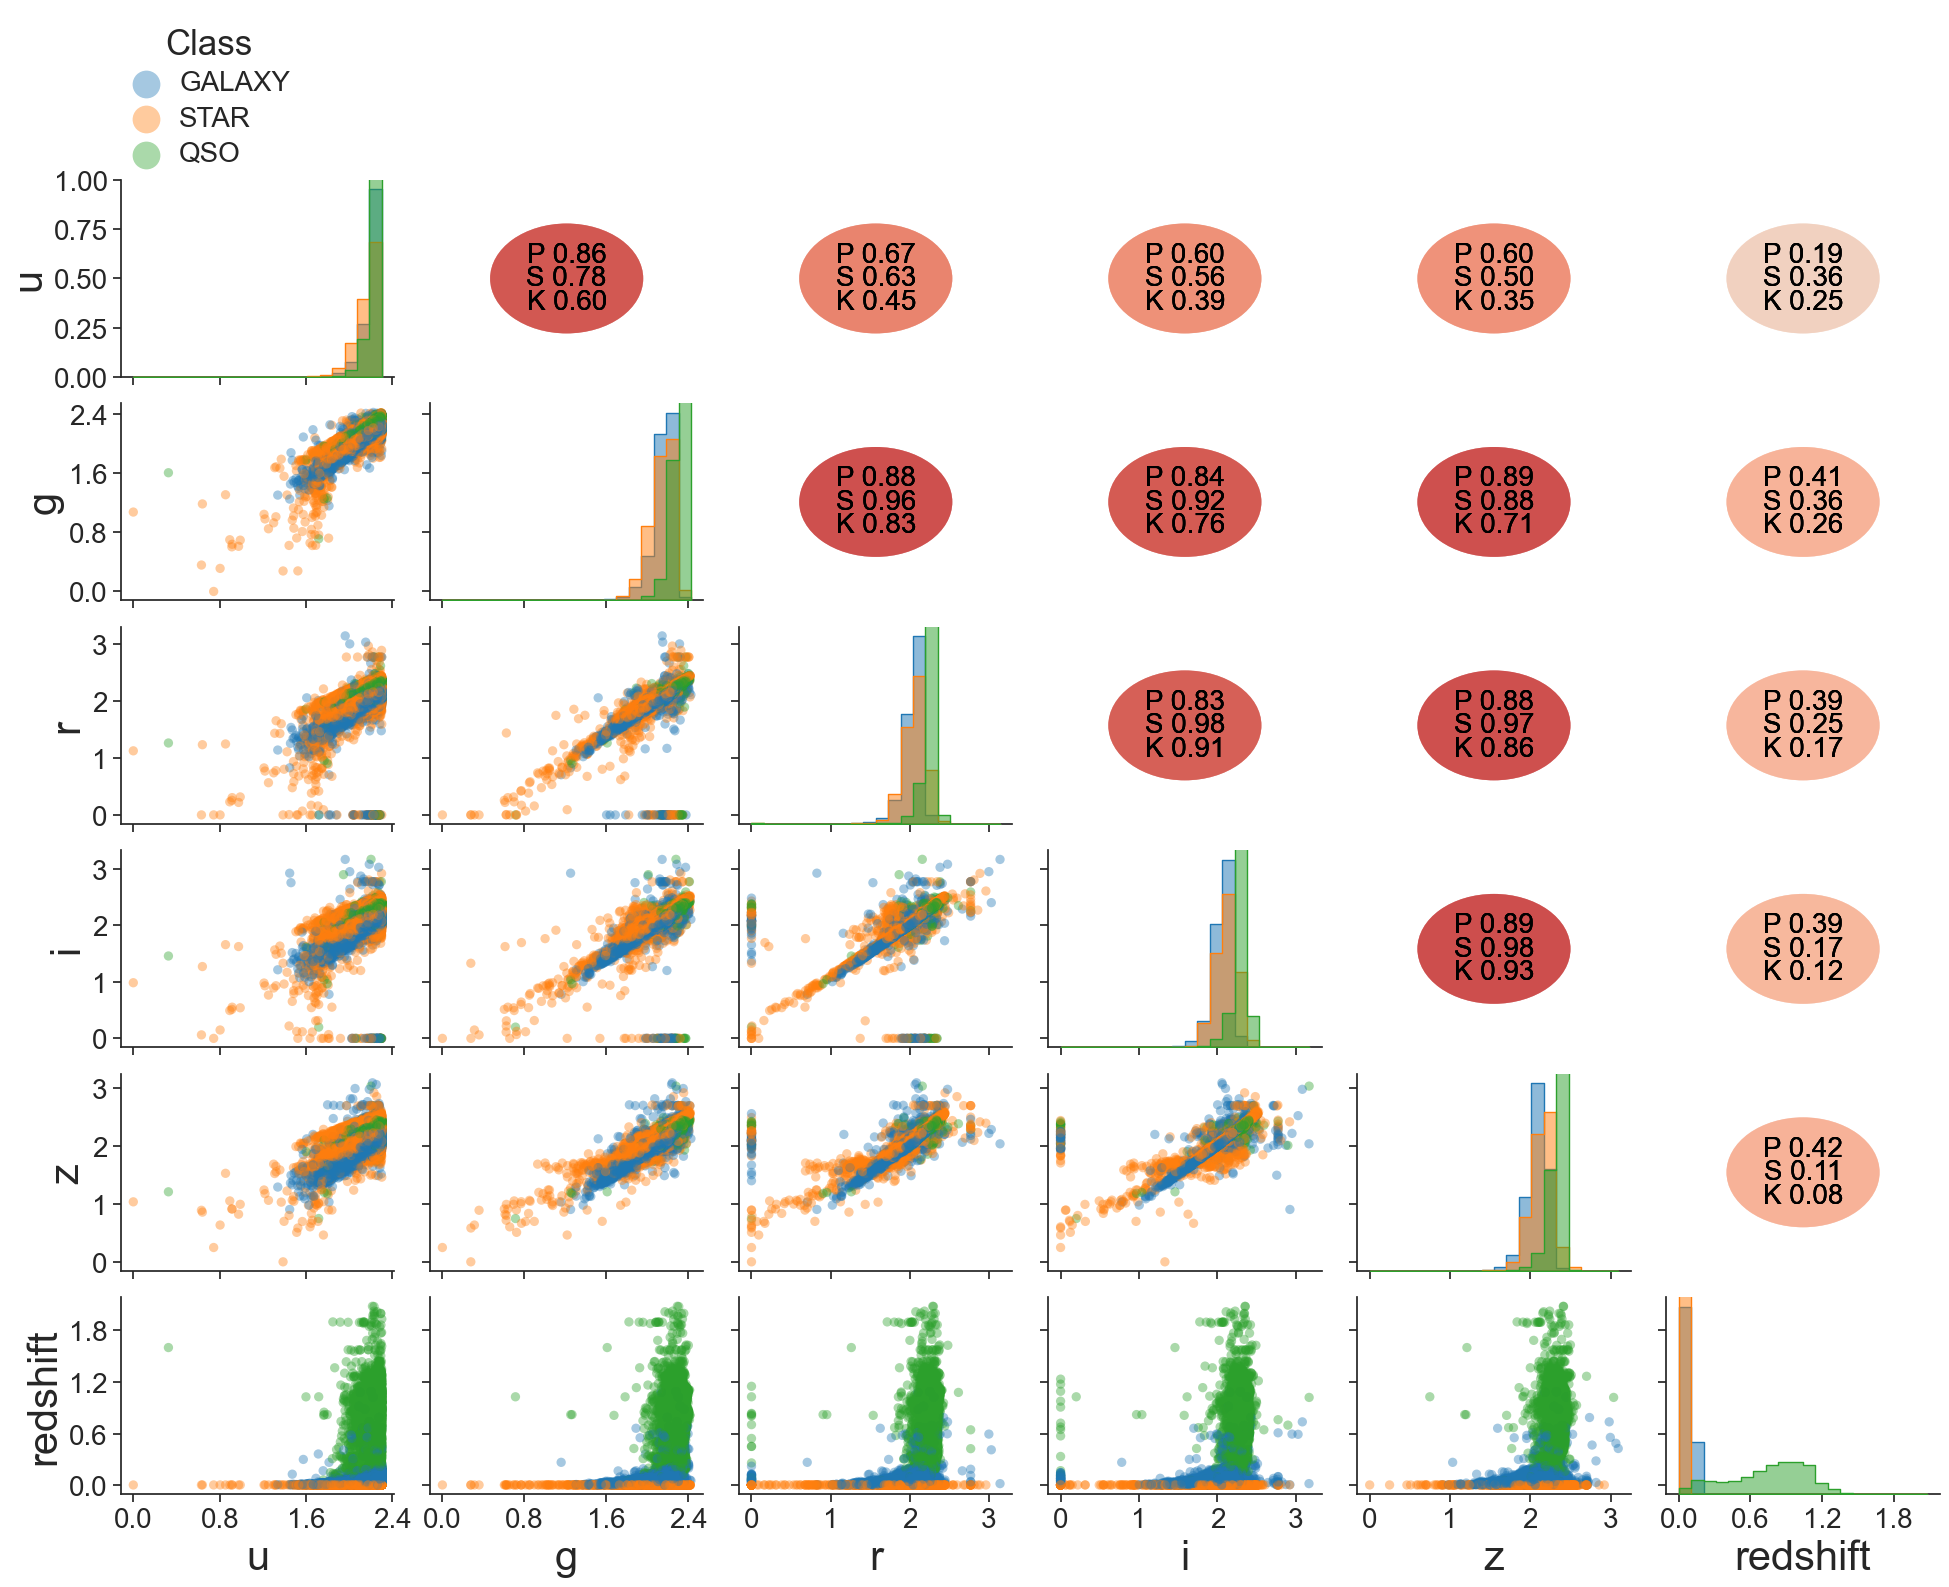

In [231]:
from functools import partial
import matplotlib as mpl
import matplotlib.ticker as mticker
from matplotlib.patches import Circle
from matplotlib.patches import Ellipse
import matplotlib.lines as mlines

def corrdot(
  x, y,
  corr_p=None, corr_s=None, corr_k=None,
  axis_aspect=None,  
  **kwargs
):
  ax = plt.gca()
  ax.set_axis_off()
  ax.set_autoscale_on(False)
  
  col_x = x.name
  col_y = y.name

  rp = corr_p.loc[col_x, col_y]
  rs = corr_s.loc[col_x, col_y]
  rk = corr_k.loc[col_x, col_y]

  cmap = mpl.colormaps["coolwarm"]  
  norm = mpl.colors.Normalize(vmin=-1, vmax=1)    
  color_p = cmap(norm(rp))
  color_s = cmap(norm(rs))
  color_k = cmap(norm(rk))  

  # - Draw ellipse background   
  radius = 0.28
  ellipse = Ellipse(
    (0.5, 0.5),
    width=2 * radius,
    height=2 * radius * axis_aspect,
    transform=ax.transAxes,
    facecolor=color_p,
    edgecolor="none",
    alpha=0.5,
    zorder=1
  )
  ax.add_patch(ellipse)  
    
  # - Three vertically spaced values
  ax.text(0.5, 0.62, f"P {rp:.2f}",
        ha="center", va="center",
        transform=ax.transAxes, fontsize=20, zorder=2, color="black")
    
  ax.text(0.5, 0.5, f"S {rs:.2f}",
        ha="center", va="center",
        transform=ax.transAxes, fontsize=20, zorder=2, color="black")

  ax.text(0.5, 0.38, f"K {rk:.2f}",
        ha="center", va="center",
        transform=ax.transAxes, fontsize=20, zorder=2, color="black")


def draw_scatter_plot(df):
  
  with sns.axes_style("ticks"), sns.plotting_context("notebook", font_scale=1.2):
    # - Create grid    
    g = sns.PairGrid(
      df[cols + ["class"]],
      hue="class",
      aspect=1.3,
      diag_sharey=False  
    )
    
    # - Add lower panels (scatter plots)
    g.map_lower(
      sns.scatterplot,
      s=45,
      alpha=0.4,
      linewidth=0,
      edgecolor=None
    )

    # - Add diagonal panels (histograms)
    def diag_hist(x, color=None, **kwargs):
      ax = plt.gca()
    
      # Compute common bins from full variable range
      full_min = df_plot[x.name].min()
      full_max = df_plot[x.name].max()
      bins = np.linspace(full_min, full_max, 21)
    
      sns.histplot(
        x,
        bins=bins,
        stat="density",
        alpha=0.5,
        color=color,
        element="step",      # cleaner overlay
        fill=True,
        ax=ax
      )
      ax.set_ylim(bottom=0)
      
    g.map_diag(diag_hist)  
    
    # - Add upper panels (correlation coeff)
    g.fig.canvas.draw()
    # Get aspect ratio from first upper axis
    sample_ax = g.axes[0, 1]
    bbox = sample_ax.get_position()
    width = bbox.width
    height = bbox.height
    axis_aspect = height / width
    
    corr_func = partial(
      corrdot,
      corr_p=corr_p,
      corr_s=corr_s,
      corr_k=corr_k,
      axis_aspect=axis_aspect  
    )
    g.map_upper(corr_func)

    # - Set axis label/ticks
    for ax in g.axes.flatten():
      ax.tick_params(axis='both', labelsize=20)
      ax.set_xlabel(ax.get_xlabel(), fontsize=30)
      ax.set_ylabel(ax.get_ylabel(), fontsize=30) 
      ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=4))
      ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4))
    
    # - Add legend
    g.add_legend(title="Class", adjust_subtitles=True)
    g._legend.get_title().set_fontsize(25)
    
    # - Move legend to top
    g._legend.set_bbox_to_anchor((0.1, 1.05))
    g._legend.set_loc("upper center")
    g._legend.set_frame_on(False)

    # - Increase label size
    for text in g._legend.texts:
      text.set_fontsize(20)

    # - Increase marker size
    for handle in g._legend.legend_handles:
      handle.set_markersize(20)
    
    g.fig.subplots_adjust(top=0.93)
           
    plt.show()
    
# - Set data for the plot
#df_plot = df_transf_nans.sample(10000, random_state=0).dropna() # Reduce number of data to plot
df_plot = df_transf_nans.copy().dropna()
    
# - Draw scatter plot
draw_scatter_plot(df_plot)

#sns.pairplot(
#  df_transf, vars=cols, hue="class", 
#  markers=["o", "s", "D"], corner=True, diag_kind="hist", plot_kws={"s": 10, "alpha": 0.7}, dropna=False
#)
#plt.show()

Below, we plot variable correlation matrix for each class, using the Pearson correlation coefficient as metric.

--> Correlation matrix
                 u         g         r         i         z  redshift
u         1.000000  0.045977  0.057366  0.062954  0.042437  0.037251
g         0.045977  1.000000  0.103412  0.102261  0.078609  0.110243
r         0.057366  0.103412  1.000000  0.168717  0.133172  0.172934
i         0.062954  0.102261  0.168717  1.000000  0.140314  0.175995
z         0.042437  0.078609  0.133172  0.140314  1.000000  0.143583
redshift  0.037251  0.110243  0.172934  0.175995  0.143583  1.000000

--> Correlation matrix for class: GALAXY
                 u         g         r         i         z  redshift
u         1.000000  0.036681  0.051581  0.059170  0.040586  0.084490
g         0.036681  1.000000  0.073057  0.078258  0.061300  0.099768
r         0.051581  0.073057  1.000000  0.129430  0.104378  0.118892
i         0.059170  0.078258  0.129430  1.000000  0.108723  0.102791
z         0.040586  0.061300  0.104378  0.108723  1.000000  0.079417
redshift  0.084490  0.099768  0.118892

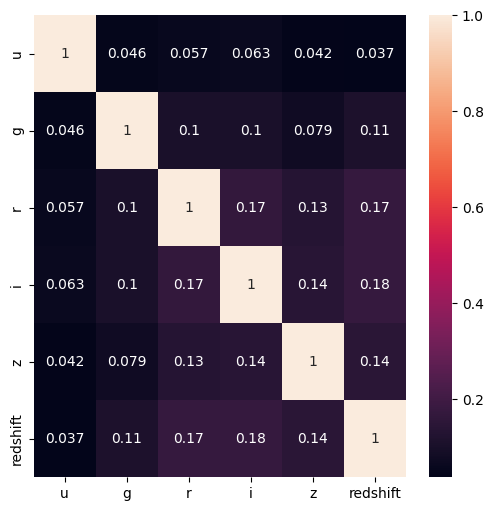

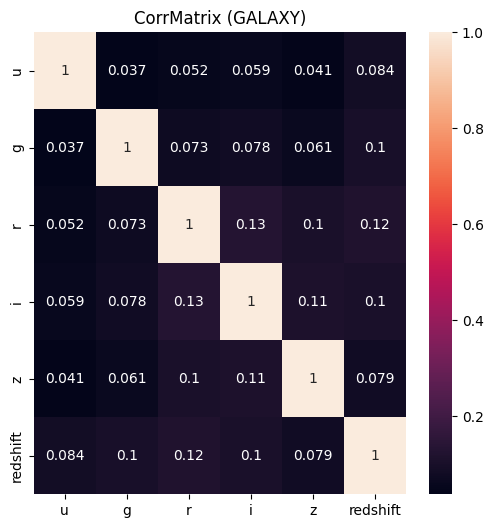

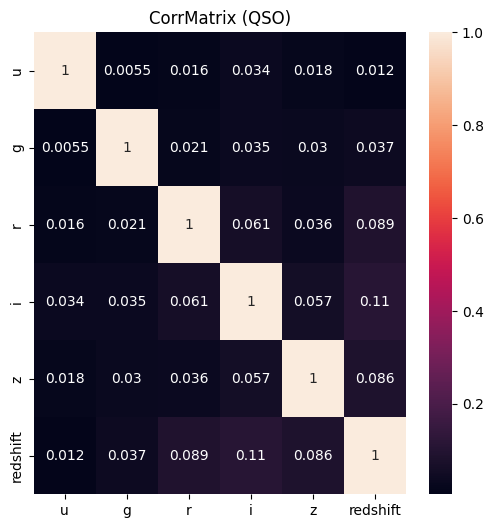

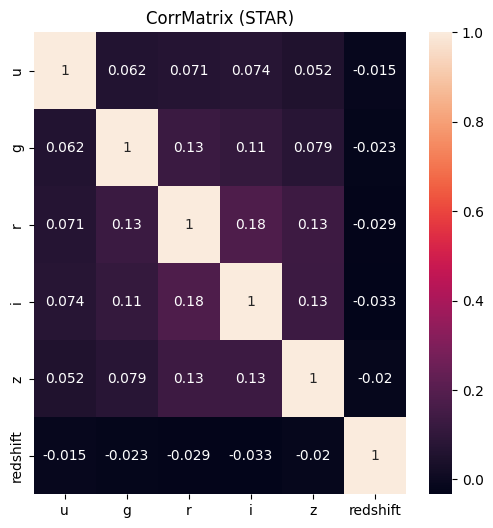

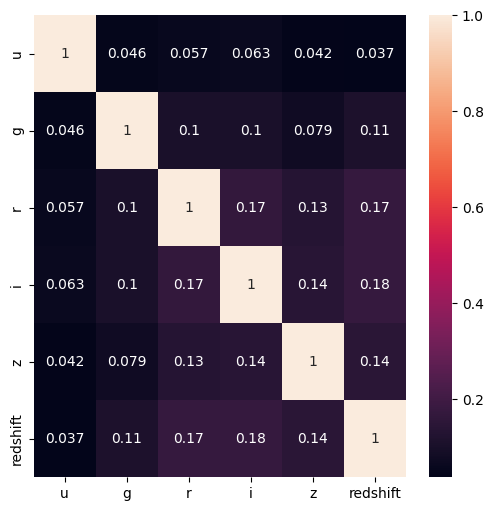

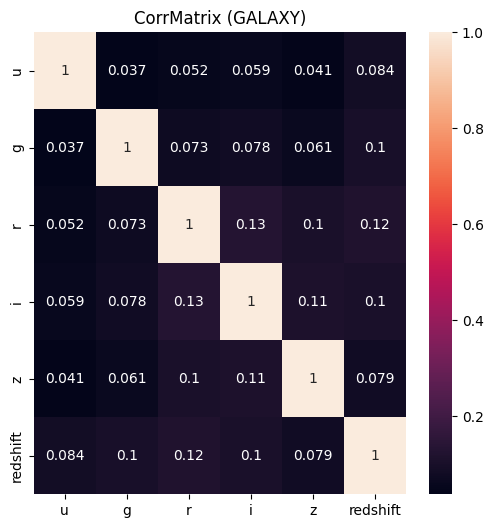


--> Correlation matrix for class: QSO
                 u         g         r         i         z  redshift
u         1.000000  0.005526  0.015736  0.034026  0.017935  0.011788
g         0.005526  1.000000  0.020524  0.035144  0.029592  0.036931
r         0.015736  0.020524  1.000000  0.061408  0.035627  0.088756
i         0.034026  0.035144  0.061408  1.000000  0.056864  0.107736
z         0.017935  0.029592  0.035627  0.056864  1.000000  0.086154
redshift  0.011788  0.036931  0.088756  0.107736  0.086154  1.000000


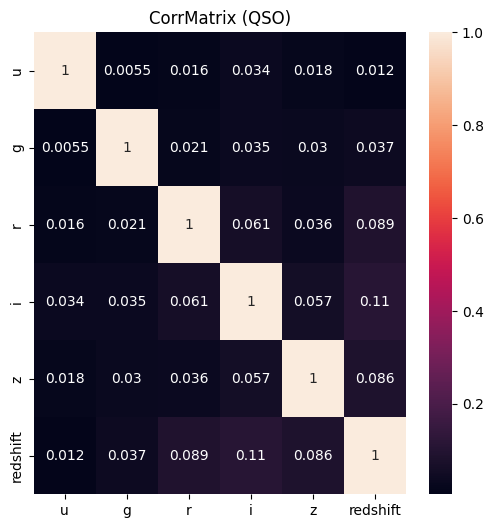


--> Correlation matrix for class: STAR
                 u         g         r         i         z  redshift
u         1.000000  0.062476  0.071057  0.074485  0.052031 -0.015454
g         0.062476  1.000000  0.125778  0.110473  0.079139 -0.022873
r         0.071057  0.125778  1.000000  0.177358  0.134040 -0.028714
i         0.074485  0.110473  0.177358  1.000000  0.132063 -0.033206
z         0.052031  0.079139  0.134040  0.132063  1.000000 -0.020452
redshift -0.015454 -0.022873 -0.028714 -0.033206 -0.020452  1.000000


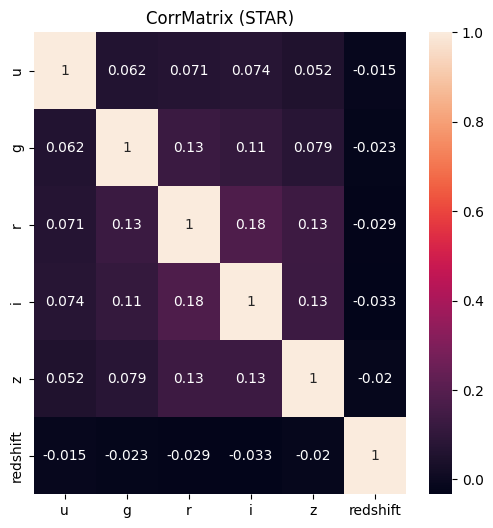

In [50]:
# - Compute and plot correlation matrix (global)
cm = df_transf.corr(method='pearson', numeric_only=True)
print("--> Correlation matrix")
print(cm)
plt.figure(figsize=(6, 6)) 
sns.heatmap(cm, annot=True)

# - Compute and plot correlation matrix per class
for cls, g in df_transf.groupby("class"):
  cm_class = g.corr(method="pearson", numeric_only=True)
  print(f"\n--> Correlation matrix for class: {cls}")
  print(cm_class)
  plt.figure(figsize=(6, 6)) 
  sns.heatmap(cm_class, annot=True)
  title= "CorrMatrix ({c})".format(c=cls)
  plt.title(title)
  plt.show()

## Dimensionality reduction
Let's project the numerical variables (4 band flux, redshift) in a 2D space, using UMAP dimensionality reduction tool.

First, we set the data for UMAP.

In [26]:
# - Set UMAP data & labels using data without NaNs rows
df_nonans= df.dropna()
X_nonans= df_nonans[cols].to_numpy() # this does not contains nans
y_nonans= df_nonans['class']

# - Set UMAP data & labels using transformed data without NaNs rows
df_transf_nonans= df_transf.copy()
df_transf_nonans.replace(to_replace=-1, value=np.nan, inplace=True)
df_transf_nonans.dropna(inplace=True)
X_transf_nonans= df_transf_nonans[cols].to_numpy() # here NANs are =-1
y_transf_nonans= df_transf_nonans['class']

# - Set UMAP data & labels using transformed data (nans set to -1)
X_transf= df_transf[cols].to_numpy() # here NANs are =-1
y_transf= df_transf['class']
has_nan_values= (
  (df_transf[cols_flux].eq(-1))
     .any(axis=1)
     .to_numpy()
     .astype(int)
)
print("#no nans")
print(np.count_nonzero(has_nan_values == 0))
print("#nans")
print(np.count_nonzero(has_nan_values == 1))

#no nans
92182
#nans
7818


Run UMAP on original data (no nans) ...


/home/riggi/Software/venvs/usc-c-ai-school-2026/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Run UMAP on transformed data (no nans) ...
Run UMAP on transformed data (nans=-1) ...


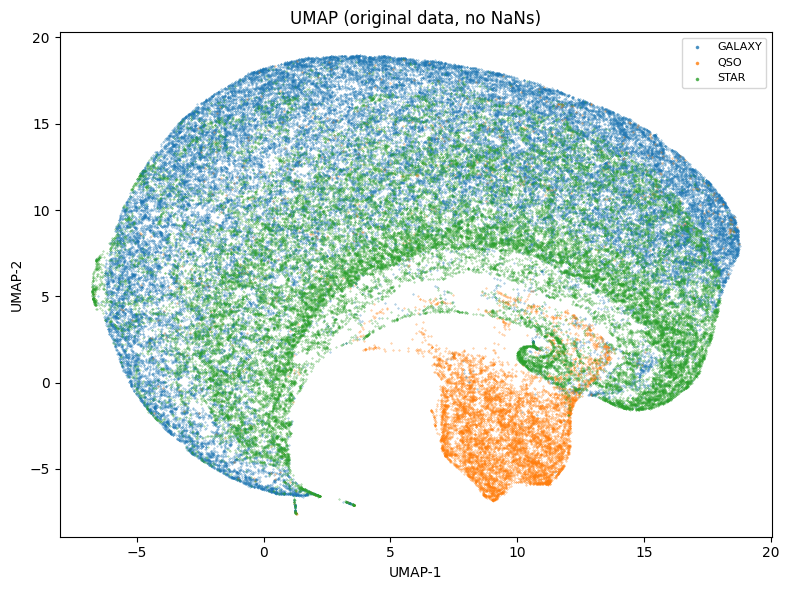

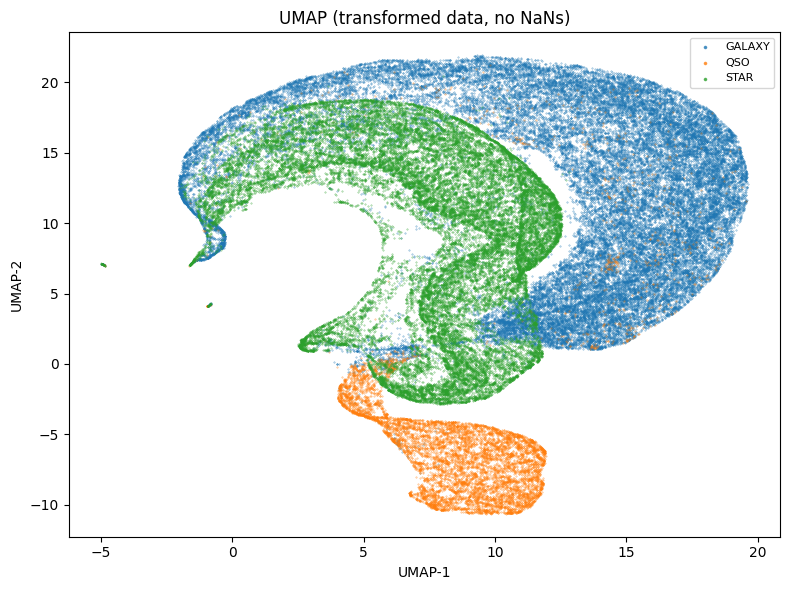

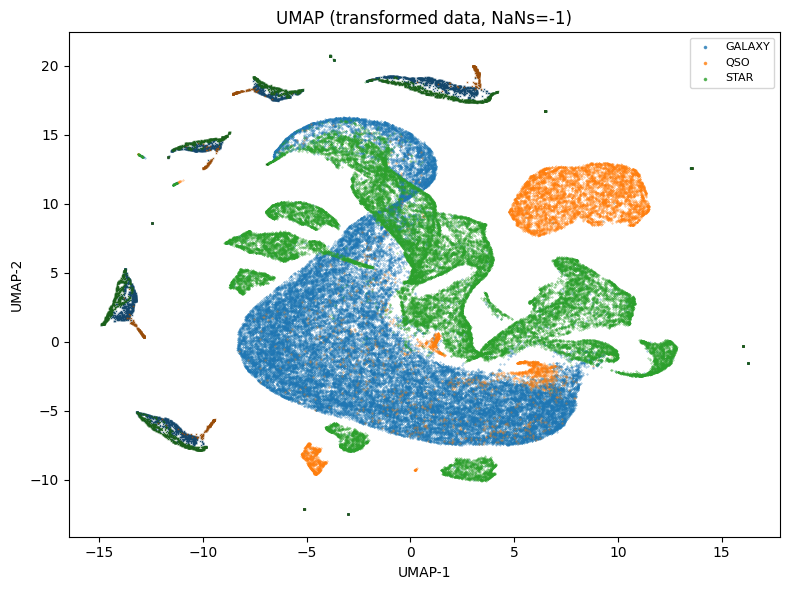

In [27]:
def plot_embeddings(
  embeddings, # embeddings 
  y, # class 
  mask=None, 
  title="UMAP projection",
  s_normal=0.1,
  s_masked=0.1,
  alpha_normal=0.7,
  alpha_masked=0.9  
):
  """ Draw UMAP embeddings """
  plt.figure(figsize=(8, 6))
  classes = np.unique(y)  
  cmap = plt.get_cmap('tab10')  
  class_to_idx = {cls: i for i, cls in enumerate(classes)}  

  for cls in np.unique(y):
    idx_cls = (y == cls)
    base_color = cmap(class_to_idx[cls])
    
    if mask is None:
      idx_normal = idx_cls
    else:
      idx_normal = idx_cls & (mask == 0)
        
    plt.scatter(
      #embeddings[idx, 0], embeddings[idx, 1],
      embeddings[idx_normal, 0], embeddings[idx_normal, 1],  
      s=s_normal,
      marker="o",  
      color=base_color,
      label=cls,
      alpha=alpha_normal
    )
    
    if mask is not None:
      # ---- masked points ----
      idx_masked = idx_cls & (mask == 1)

      # slightly darker version of class color
      darker = tuple(np.clip(np.array(base_color[:3]) * 0.6, 0, 1))

      plt.scatter(
        embeddings[idx_masked, 0],
        embeddings[idx_masked, 1],
        s=s_masked,
        color=darker,
        marker="x",
        alpha=alpha_masked
      )

  plt.title(title)
  plt.xlabel("UMAP-1")
  plt.ylabel("UMAP-2")
  plt.legend(markerscale=5, fontsize=8)
  plt.tight_layout()
  plt.show()


# - Init UMAP: play with n_neighbors & min_dist parameters
umap= UMAP(
  n_components=2,
  n_neighbors=30, 
  min_dist=0.2,
  random_state=42
)

# - Run UMAP on original & transformed data
print("Run UMAP on original data (no nans) ...")
X_nonans_embed= umap.fit_transform(X_nonans)

print("Run UMAP on transformed data (no nans) ...")
X_transf_nonans_embed= umap.fit_transform(X_transf_nonans)

print("Run UMAP on transformed data (nans=-1) ...")
X_transf_embed= umap.fit_transform(X_transf)

# - Plot UMAP embeddings on original & transformed data
plot_embeddings(X_nonans_embed, y_nonans, mask=None, title="UMAP (original data, no NaNs)")
plot_embeddings(X_transf_nonans_embed, y_transf_nonans, mask=None, title="UMAP (transformed data, no NaNs)")
plot_embeddings(X_transf_embed, y_transf, mask=has_nan_values, title="UMAP (transformed data, NaNs=-1)")

# Data cleaning
We are now going to demonstrate a possible data cleaning pipeline applied on raw data:

- Step 1: Extreme outlier identification with simple method (IQR)
- Step 2: Missing data imputation with simple method (median)
- Step 3: Refined outlier identification with more advanced methods (LOF/IF)
- Step 4: Refined missing data imputation with more advanced methods (IterativeImputer)

## Step 1: Extreme outlier identification
Let's search for possible outliers in each columns. We will first use simple methods (IQR-based) to identify the most extreme outliers, and later on (Step 3) we will report to more advanced methods (e.g. LOF, IsolationForest) to refine the outlier search.

First, let's first make a box plot of each numeric data variable.

<Axes: >

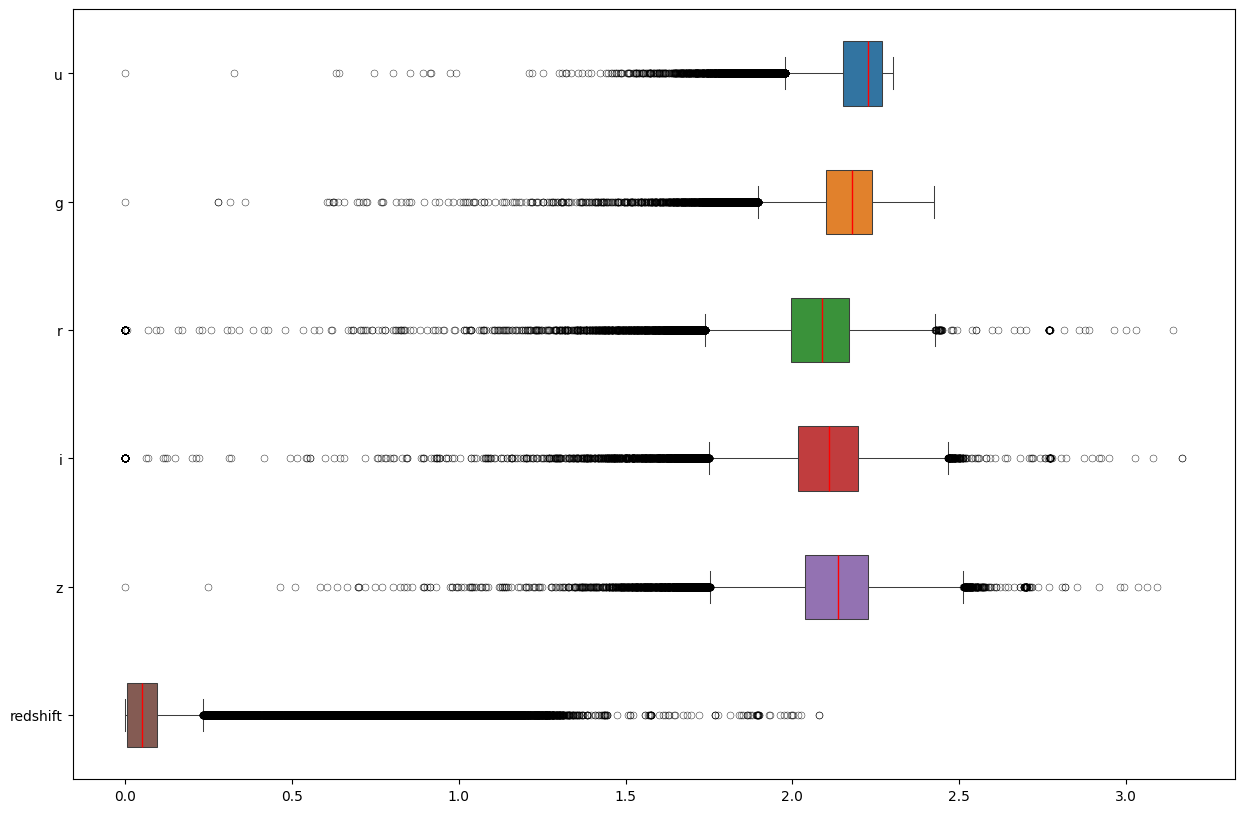

In [28]:
df_transf_copy= df_transf.copy()
df_transf_copy.replace(to_replace=-1, value=np.nan, inplace=True)

# - Define outlier properties
flierprops = dict(marker='o', markerfacecolor='None', markersize=5, markeredgecolor='black', 
                  markeredgewidth=0.3)
medianprops={"color": "r", "linewidth": 1}

# - Box plot
plt.figure(figsize=(15, 10)) 
sns.boxplot(data=df_transf_copy[cols], 
            linewidth=.75, width=.5, 
            orient="h", showmeans=False, medianprops=medianprops, 
            flierprops=flierprops, whis=1.5)

### Interquartile Range method
This is perhaps the most simple and robust method for finding outliers, suitable for non-normal data 
distributions. The method identifies data points falling 1.5 times the IQR below the first quartile (Q1) or 
above the third quartile (Q3). It thus only requires sorting data to find quartiles (Q1, Q3), and calculating 
IQR= Q3-Q1. We will use a less stringent outlier range, e.g. setting the bounds to:

lower= Q1 - 3.0 x IQR
upper= Q3 + 3.0 x IQR

Let's therefore compute the Q1 & Q3 quartiles of the data. We are using the log-transformed data.

In [30]:
Q1 = df_transf_copy[cols].quantile(0.25)
Q3 = df_transf_copy[cols].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 3.0 * IQR
upper = Q3 + 3.0 * IQR

print("Q1")
print(Q1)
print("Q3")
print(Q3)
print("IQR")
print(IQR)
print("lower_bound")
print(lower)
print("upper_bound")
print(upper)

Q1
u           2.152774
g           2.102400
r           1.997758
i           2.018685
z           2.037990
redshift    0.004131
Name: 0.25, dtype: float64
Q3
u           2.268140
g           2.239237
r           2.170243
i           2.197854
z           2.228120
redshift    0.095149
Name: 0.75, dtype: float64
IQR
u           0.115365
g           0.136837
r           0.172484
i           0.179169
z           0.190129
redshift    0.091018
dtype: float64
lower_bound
u           1.806679
g           1.691890
r           1.480305
i           1.481178
z           1.467603
redshift   -0.268924
dtype: float64
upper_bound
u           2.614235
g           2.649748
r           2.687696
i           2.735362
z           2.798507
redshift    0.368204
dtype: float64


We can either remove the outliers (entire row) from the data and create a new data frame with outliers removed **OR** we can set them to NaN values, keep them and impute them in the following pipeline steps.

The following code completely removes the outliers from the dataset.

In [31]:
#mask = df_transf_copy[cols].ge(lower).all(axis=1) & df_transf_copy[cols].le(upper).all(axis=1)
#df_clean_step1 = df_transf_copy.loc[mask].copy()

in_range = (
  df_transf_copy[cols].ge(lower) &
  df_transf_copy[cols].le(upper)
)

# Treat NaNs as valid (ignore them)
mask = (in_range | df_transf_copy[cols].isna()).all(axis=1)
df_clean_step1 = df_transf_copy.loc[mask].copy()

print(df_clean_step1)

n_before = len(df_transf_copy)
n_after = mask.sum()

print(f"Rows before: {n_before}")
print(f"Rows after: {n_after}")
print(f"Removed rows: {n_before - n_after}")

# - Counts removed rows (ignoring NaNs)
in_range = df_transf_copy[cols].ge(lower) & df_transf_copy[cols].le(upper)
mask_keep = in_range | df_transf_copy[cols].isna()
mask_keep = mask_keep.all(axis=1)
removed_rows = (~mask_keep).sum()
print("Removed rows (ignoring NaNs):", removed_rows)

# - Count how many columns have more than 1 outlier
outlier_cells = df_transf_copy[cols].lt(lower) | df_transf_copy[cols].gt(upper)
rows_outlier_counts = outlier_cells.sum(axis=1)
n_2plus = (rows_outlier_counts >= 2).sum()
print("Rows with >=2 outlier columns:", n_2plus)

print("Outlier counts")
outlier_counts = outlier_cells.sum(axis=1)
print(outlier_counts.value_counts().sort_index())

for X in range(1, 6):
  n = (outlier_counts > X).sum()
  print(f"Rows with > {X} outliers: {n}")

               u         g         r         i         z  redshift   class
0            NaN  2.171097  2.084649  2.095145  2.121302  0.144278  GALAXY
1       2.191312  2.066912  1.913392  1.922731  1.930075  0.099123  GALAXY
3       2.202160  2.176309  2.109996  2.147579  2.184472  0.004008    STAR
4       2.127816  2.099761  2.030986  2.076653  2.117667  0.004397    STAR
5       2.256286  2.253554  2.201341  2.237581  2.273587  0.003639    STAR
...          ...       ...       ...       ...       ...       ...     ...
101994  2.175660  2.179642  2.124757  2.168944  2.206190  0.005064    STAR
101995  2.272589  2.229333  2.150194  2.183171  2.210361  0.004336    STAR
101996  2.281834  2.248874  2.179048  2.189386  2.209752  0.072824  GALAXY
101998       NaN  1.759983  1.534919  1.506574  1.502123  0.028155  GALAXY
101999  2.221428  2.216486  2.158917  2.195798  2.229542  0.003502    STAR

[90288 rows x 7 columns]
Rows before: 100000
Rows after: 90288
Removed rows: 9712
Removed rows (ign

<Axes: >

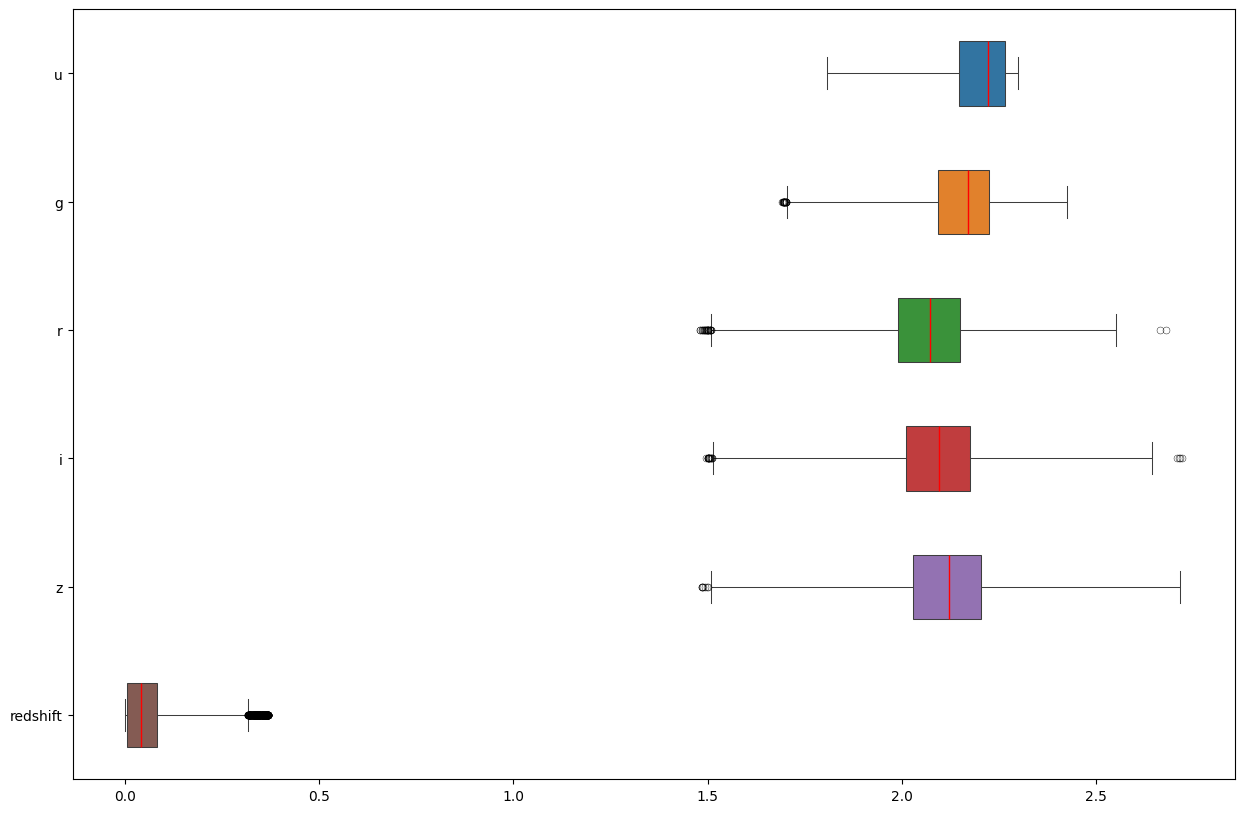

In [32]:
# - Make box plot with cleaned data 
#   NB: setting whisker attribute to 3.0, default=1.5) to check we effectively removed the outliers
plt.figure(figsize=(15, 10)) 
sns.boxplot(data=df_clean_step1[cols], 
            linewidth=.75, width=.5, 
            orient="h", showmeans=False, medianprops=medianprops, 
            flierprops=flierprops, whis=3.0)

The following code replaces the outliers found the dataset with NaN values.

In [33]:
df_clean_step1 = df_transf_copy.copy()

# - Create boolean mask of outliers (cell-wise)
outlier_mask = (
  df_clean_step1[cols].lt(lower) |
  df_clean_step1[cols].gt(upper)
)

# - Replace outliers with NaN
df_clean_step1.loc[:, cols] = df_clean_step1[cols].mask(outlier_mask, np.nan)
n_outliers = outlier_mask.sum().sum()
print(f"Replaced {n_outliers} values with NaN")

Replaced 10876 values with NaN


Let's make a box plot of the cleaned data.

<Axes: >

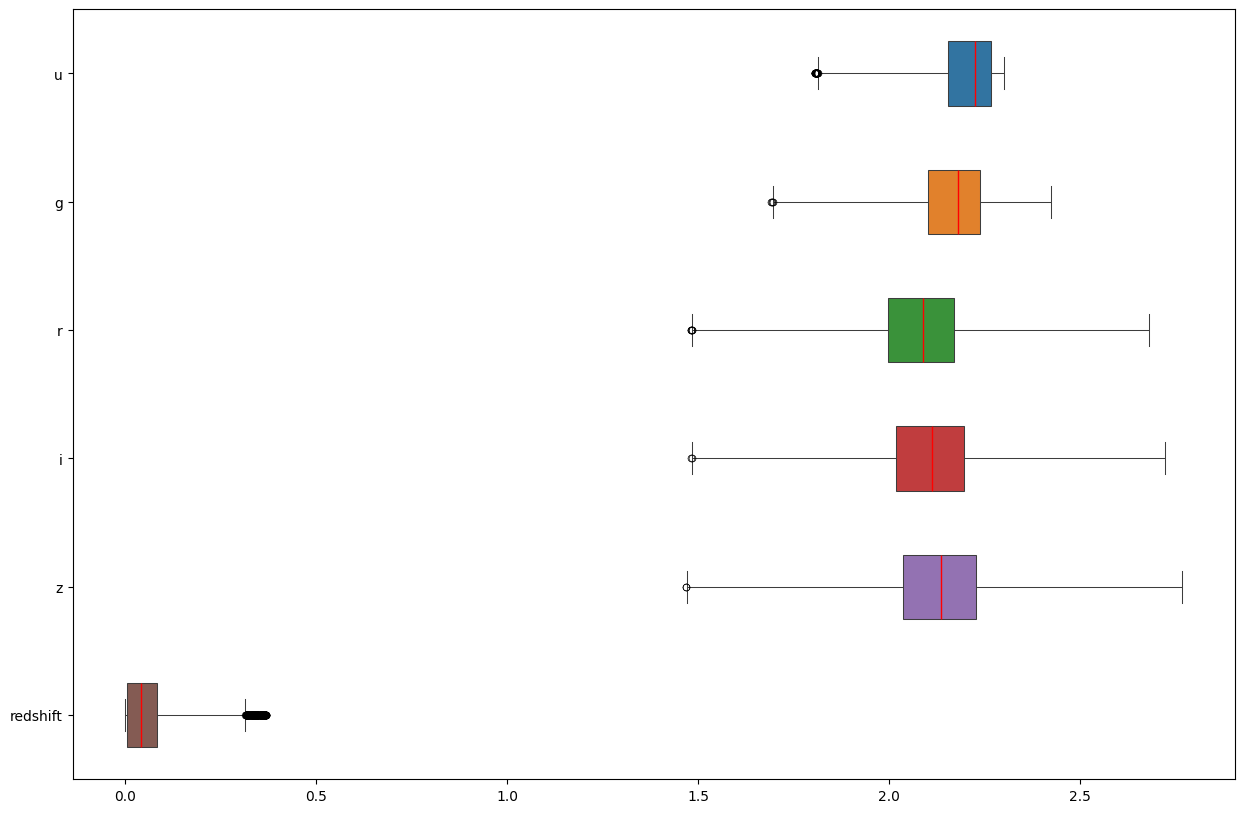

In [34]:
# - Make box plot with cleaned data 
#   NB: setting whisker attribute to 3.0, default=1.5) to check we effectively removed the outliers
plt.figure(figsize=(15, 10)) 
sns.boxplot(data=df_clean_step1[cols], 
            linewidth=.75, width=.5, 
            orient="h", showmeans=False, medianprops=medianprops, 
            flierprops=flierprops, whis=3.0)

## Step 2: Handling of missing data
In this stage, we will perform missing data imputation on the cleaned data obtained in the previous stage (no extreme outliers).

We will use the multivariate imputation method implemented in `sklearn IterativeImputer`. It supports multiple imputation with different estimators (e.g. regression, kNN, random forest, etc). 
Below, we define an helper method to run it, eventually performing multiple rounds of imputations. 

In [35]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
    
# - Define an helper function to run imputation
def get_imputed_data(X, mi_enabled=False, seed=0):
  """ Run iterative imputation and returns data with imputed values """  
  # - Define imputer class
  #   An iteration is a single imputation of each feature with missing values  
  imputer= IterativeImputer(
    estimator=BayesianRidge(),    # Default, but you can use other methods here (e.g. RandomForest, etc)
    n_nearest_features=None,      # All features used
    imputation_order='ascending', # Impute from features with fewest to most missing values
    initial_strategy='median',      # Initialization imputation method
    max_iter=10,                  # Max number of iterations
    sample_posterior=mi_enabled,  # False to disable multiple imputation
    random_state=seed
  )

  # - Fit imputer and get the dataset with imputed data
  X_imp= imputer.fit_transform(X)
  return X_imp

For this tutorial, we will run the imputation method only once with random drawn disabled (single imputation).

In [36]:
# - Set data to be used for imputation (the numeric columns)
sel_cols= df_clean_step1.select_dtypes(include=[np.number]).columns
X = df_clean_step1[sel_cols].copy()
y = df_clean_step1["class"].copy()
print(X)

# - Impute data
X_imputed= get_imputed_data(X, seed=42, mi_enabled=False)

# - Set final output cleaned data
df_clean_step2 = pd.DataFrame(
  X_imputed,
  columns=sel_cols,
  index=X.index
)
df_clean_step2["class"] = y
print(df_clean_step2)

               u         g         r         i         z  redshift
0            NaN  2.171097  2.084649  2.095145  2.121302  0.144278
1       2.191312  2.066912  1.913392  1.922731  1.930075  0.099123
2            NaN  1.929527  1.972835  2.081477  2.164165  0.004158
3       2.202160  2.176309  2.109996  2.147579  2.184472  0.004008
4       2.127816  2.099761  2.030986  2.076653  2.117667  0.004397
...          ...       ...       ...       ...       ...       ...
101995  2.272589  2.229333  2.150194  2.183171  2.210361  0.004336
101996  2.281834  2.248874  2.179048  2.189386  2.209752  0.072824
101997  2.220891  2.277972  2.275484  2.306781  2.350632       NaN
101998       NaN  1.759983  1.534919  1.506574  1.502123  0.028155
101999  2.221428  2.216486  2.158917  2.195798  2.229542  0.003502

[100000 rows x 6 columns]
               u         g         r         i         z  redshift   class
0       2.188547  2.171097  2.084649  2.095145  2.121302  0.144278  GALAXY
1       2.191312  2

/home/riggi/Software/venvs/usc-c-ai-school-2026/lib/python3.10/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Let's view a scatter plot of the imputed data.

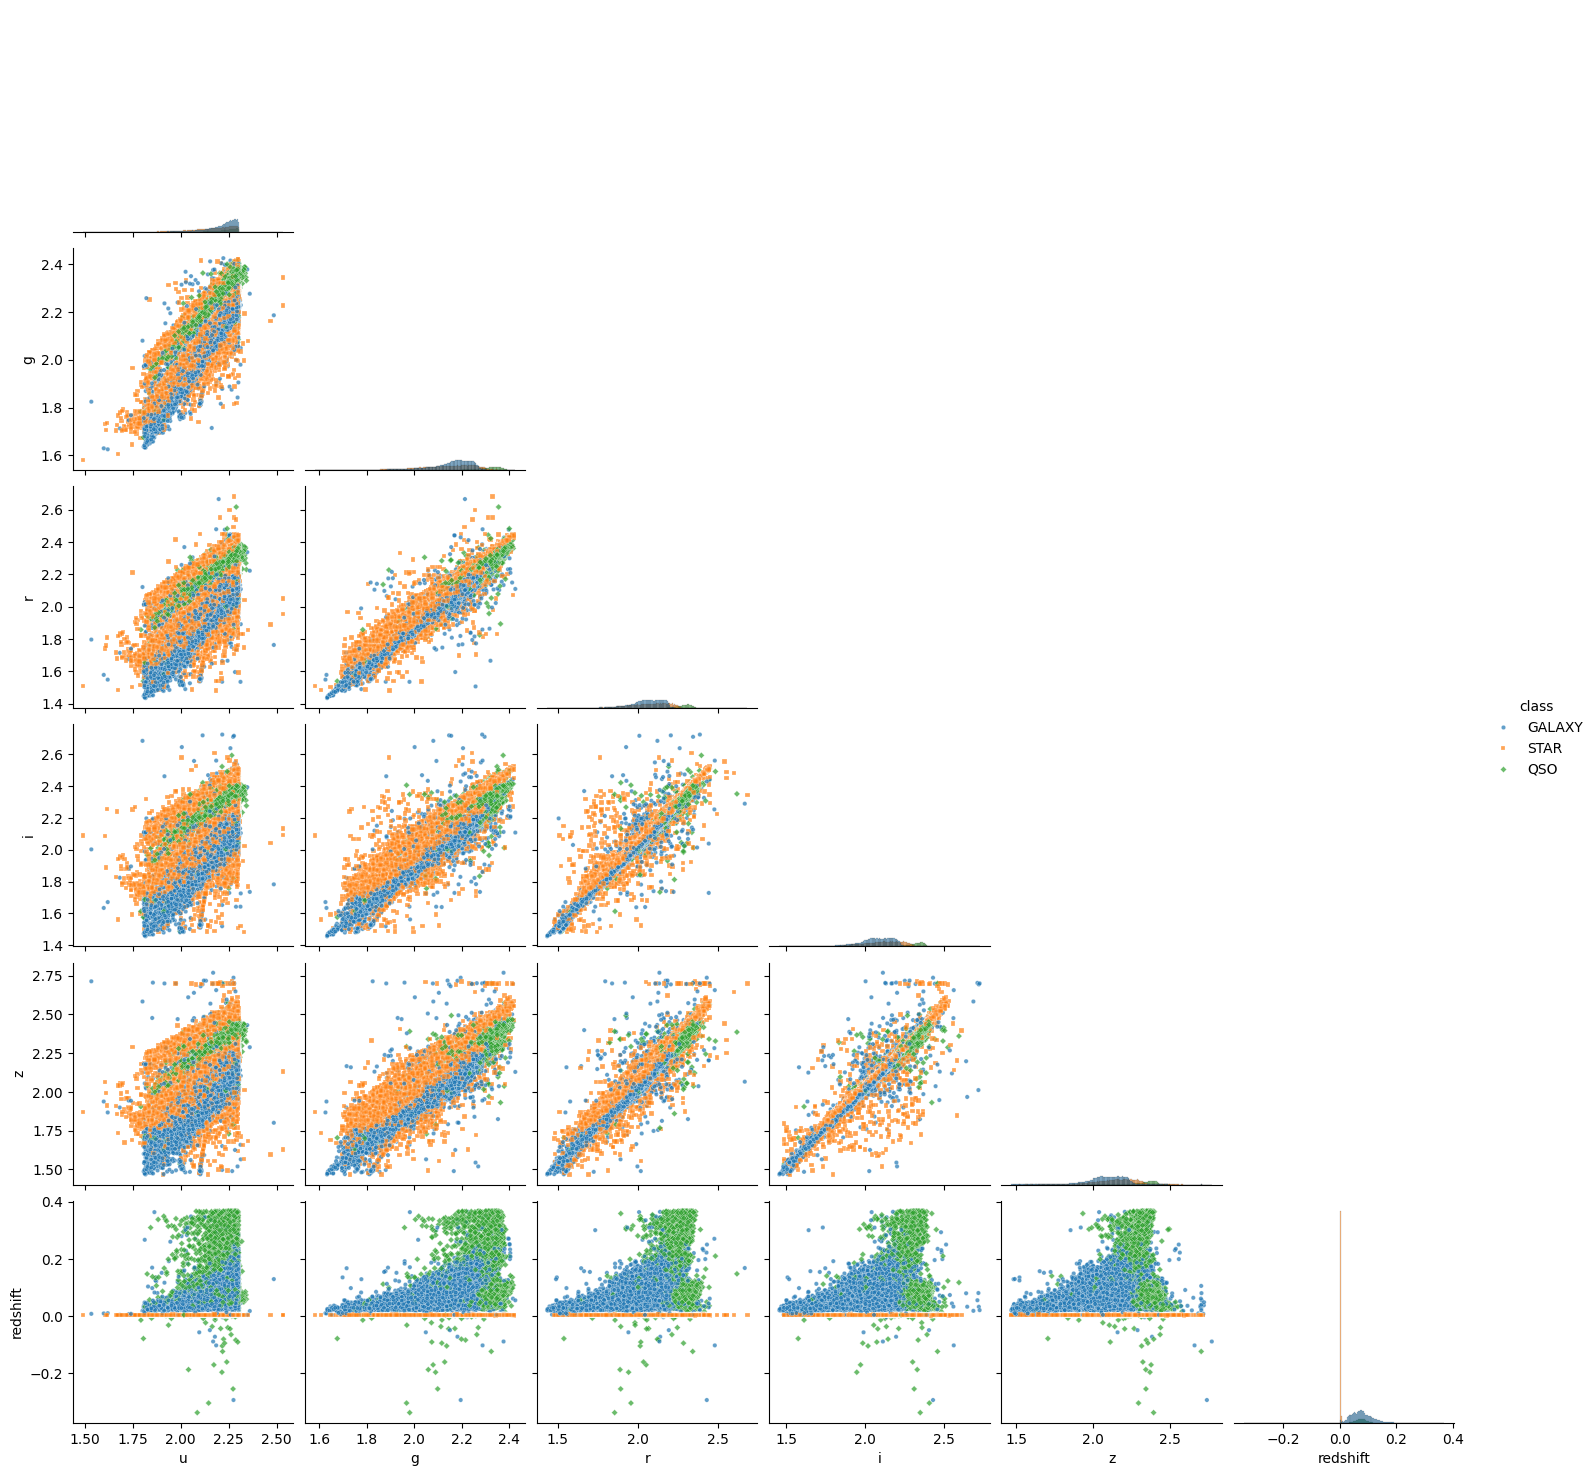

In [37]:
# - Draw scatter plot
sns.pairplot(df_clean_step2, vars=cols, hue="class", 
             markers=["o", "s", "D"], corner=True, diag_kind="hist", plot_kws={"s": 10, "alpha": 0.7}, dropna=False)

Let's make a UMAP 2D plot of the final cleaned data.

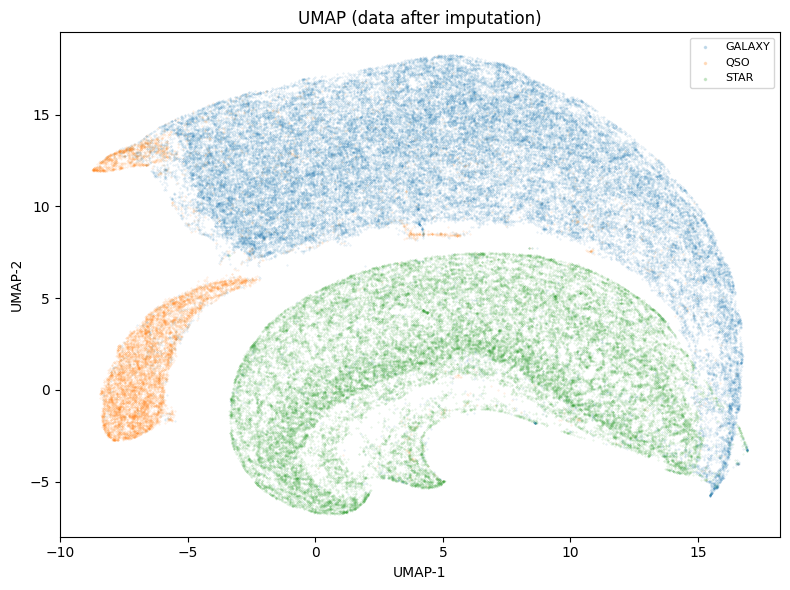

In [38]:
# - Set data for UMAP projection
X_clean_step2= df_clean_step2[cols]
y_clean_step2= df_clean_step2["class"]

# - Scale data before UMAP
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_clean_step2)

# - Run UMAP & plot embeddings
X_clean_step2_embed= umap.fit_transform(X_scaled)

plot_embeddings(
  X_clean_step2_embed, 
  y_clean_step2, 
  mask=None, 
  title="UMAP (data after imputation)",
  s_normal=0.1,
  s_masked=0.1,
  alpha_normal=0.2,
  alpha_masked=0.2  
)

## Step 3: Refined search of outliers
So far, we have removed outliers from the data using the simple IQR range method. This allowed us to obtain a preliminary cleaned dataset, that still had missing values. We imputed missing values using different methods, obtaining a preliminary cleaned dataset. 

We now revisit outlier detection, applying advanced outlier detection algorithms, like LOF or IsolationForest. They both require a fully observed dataset (e.g. no NaNs), so we run them on the preliminary cleaned dataset. 

### Local Outlier Factor method
Local Outlier Factor (LOF) is an unsupervised anomaly detection method, considering outliers as the observations having a substantially lower density than their neighbors. It compares the local density of a point to local density of its k-nearest neighbors and gives a score as final output.

The algorithm is based on the following steps:

1) Compute the local density deviation of a given data point with respect to its neighbors, e.g. find k-nearest-neighbors N_k for each data point x;
2) Compute the local density for a data point using the local reachability density (LRD) (inverse of the average reachability distance (RD) of its neighbors);
3) Compute the LOF score by comparing the LRD of a point with the LRD’s of its k-neighbors.  

The returned LOF score captures the "degree of abnormality", as the average of the ratio of the local reachability density of a sample and those of its k-nearest neighbors. **Inliers tend to have a LOF score close to 1, while outliers tend to have a larger LOF score.**


The main algorithm parameters to be set by the user are:

- Number of neighbors `NN`, typically greater than the minimum number of observations a cluster has to contain, and smaller than the maximum number of close by observations that can potentially be local outliers.
- Contamination `C`, i.e. the proportion of outliers in the data set

Let's apply the method on our log-transformed data.

In [39]:
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import LocalOutlierFactor

# - Set data to be used for outlier search (the numeric columns)
X = df_clean_step2[sel_cols].copy()
y = df_clean_step2["class"].copy()
print(X)

# - Scale features using previous scaler
X_scaled = scaler.transform(X)
print(X_scaled.shape)

# - Init LOF algorithm
#   NB: Experiment with parameters: n_neighbors & contamination
lof = LocalOutlierFactor(
  n_neighbors=20, 
  contamination=0.005, 
  novelty=False
)

# - Search outliers
y_pred = lof.fit_predict(X_scaled) # Returns -1 for outliers and +1 for inliers
inlier_mask = (y_pred == 1)
outlier_mask = (y_pred == -1)
threshold= lof.offset_ # Returns the threshold used to mark outliers (<threshold=outliers)

# - Obtain scores (more negative => more abnormal)
scores = lof.negative_outlier_factor_

# - Create new data frame with flags/scores (useful for plotting & debugging)
df_lof = df_clean_step2.copy()
df_lof["lof_is_outlier"] = outlier_mask.astype(int)
df_lof["lof_score"] = scores

# - Filtered dataframe (Step 3 result)
df_clean_step3 = df_lof.loc[inlier_mask].copy()

print("Rows before LOF:", len(df_clean_step2))
print("Rows after LOF:", len(df_clean_step3))
print("Removed by LOF:", (~inlier_mask).sum())

               u         g         r         i         z  redshift
0       2.188547  2.171097  2.084649  2.095145  2.121302  0.144278
1       2.191312  2.066912  1.913392  1.922731  1.930075  0.099123
2       1.836542  1.929527  1.972835  2.081477  2.164165  0.004158
3       2.202160  2.176309  2.109996  2.147579  2.184472  0.004008
4       2.127816  2.099761  2.030986  2.076653  2.117667  0.004397
...          ...       ...       ...       ...       ...       ...
101995  2.272589  2.229333  2.150194  2.183171  2.210361  0.004336
101996  2.281834  2.248874  2.179048  2.189386  2.209752  0.072824
101997  2.220891  2.277972  2.275484  2.306781  2.350632  0.048307
101998  2.003364  1.759983  1.534919  1.506574  1.502123  0.028155
101999  2.221428  2.216486  2.158917  2.195798  2.229542  0.003502

[100000 rows x 6 columns]
(100000, 6)
Rows before LOF: 100000
Rows after LOF: 99500
Removed by LOF: 500


Let's make a UMAP 2D plot to view inliers & outliers. 

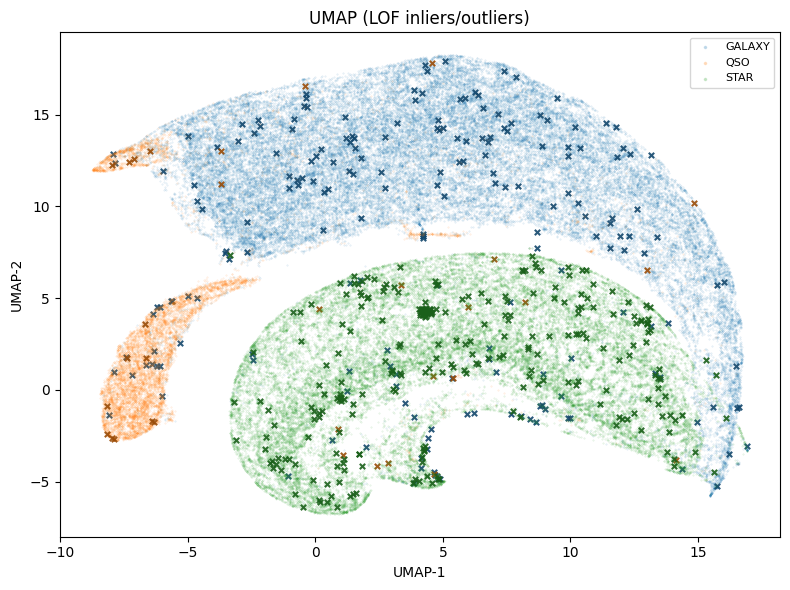

In [40]:
X_clean_step3= df_lof[cols]
X_scaled = scaler.transform(X_clean_step3)
y_clean_step3= df_lof["class"]
outlier_mask = df_lof["lof_is_outlier"].values
X_clean_step3_embed= umap.fit_transform(X_scaled)
plot_embeddings(
  X_clean_step3_embed, 
  y_clean_step3, 
  mask=outlier_mask, 
  title="UMAP (LOF inliers/outliers)",
  s_normal=0.1,
  s_masked=15,
  alpha_normal=0.2,
  alpha_masked=0.9  
)

## Step 4: Refined missing data imputation
In this final stage, we revisit missing data imputation, refining it after we removed the outliers in Step 3. 
For this, we need to restart from the cleaned data output produced in Step 1, and remove the outliers of Step 3.

In [41]:
# - Get the index of inliers and restore dataset of step 1 (with NaNs) but without outliers found in step 3
inlier_index = df_lof.index[df_lof["lof_is_outlier"] == 0]
df_step4 = df_clean_step1.loc[inlier_index].copy()
print(df_step4)

               u         g         r         i         z  redshift   class
0            NaN  2.171097  2.084649  2.095145  2.121302  0.144278  GALAXY
1       2.191312  2.066912  1.913392  1.922731  1.930075  0.099123  GALAXY
2            NaN  1.929527  1.972835  2.081477  2.164165  0.004158    STAR
3       2.202160  2.176309  2.109996  2.147579  2.184472  0.004008    STAR
4       2.127816  2.099761  2.030986  2.076653  2.117667  0.004397    STAR
...          ...       ...       ...       ...       ...       ...     ...
101995  2.272589  2.229333  2.150194  2.183171  2.210361  0.004336    STAR
101996  2.281834  2.248874  2.179048  2.189386  2.209752  0.072824  GALAXY
101997  2.220891  2.277972  2.275484  2.306781  2.350632       NaN     QSO
101998       NaN  1.759983  1.534919  1.506574  1.502123  0.028155  GALAXY
101999  2.221428  2.216486  2.158917  2.195798  2.229542  0.003502    STAR

[99500 rows x 7 columns]


We now perform imputation.

In [46]:
# - Set input data for the imputation
X = df_step4[sel_cols].copy()
y = df_step4["class"].copy()

# - Impute data
X_imputed= get_imputed_data(X, seed=42, mi_enabled=False)

# - Set final output cleaned data
df_clean_step4 = pd.DataFrame(
  X_imputed,
  columns=sel_cols,
  index=X.index
)
df_clean_step4["class"] = y
print(df_clean_step4)

               u         g         r         i         z  redshift   class
0       2.186936  2.171097  2.084649  2.095145  2.121302  0.144278  GALAXY
1       2.191312  2.066912  1.913392  1.922731  1.930075  0.099123  GALAXY
2       1.829095  1.929527  1.972835  2.081477  2.164165  0.004158    STAR
3       2.202160  2.176309  2.109996  2.147579  2.184472  0.004008    STAR
4       2.127816  2.099761  2.030986  2.076653  2.117667  0.004397    STAR
...          ...       ...       ...       ...       ...       ...     ...
101995  2.272589  2.229333  2.150194  2.183171  2.210361  0.004336    STAR
101996  2.281834  2.248874  2.179048  2.189386  2.209752  0.072824  GALAXY
101997  2.220891  2.277972  2.275484  2.306781  2.350632  0.050006     QSO
101998  2.004405  1.759983  1.534919  1.506574  1.502123  0.028155  GALAXY
101999  2.221428  2.216486  2.158917  2.195798  2.229542  0.003502    STAR

[99500 rows x 7 columns]


/home/riggi/Software/venvs/usc-c-ai-school-2026/lib/python3.10/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Let's view a scatter plot of the final cleaned data.

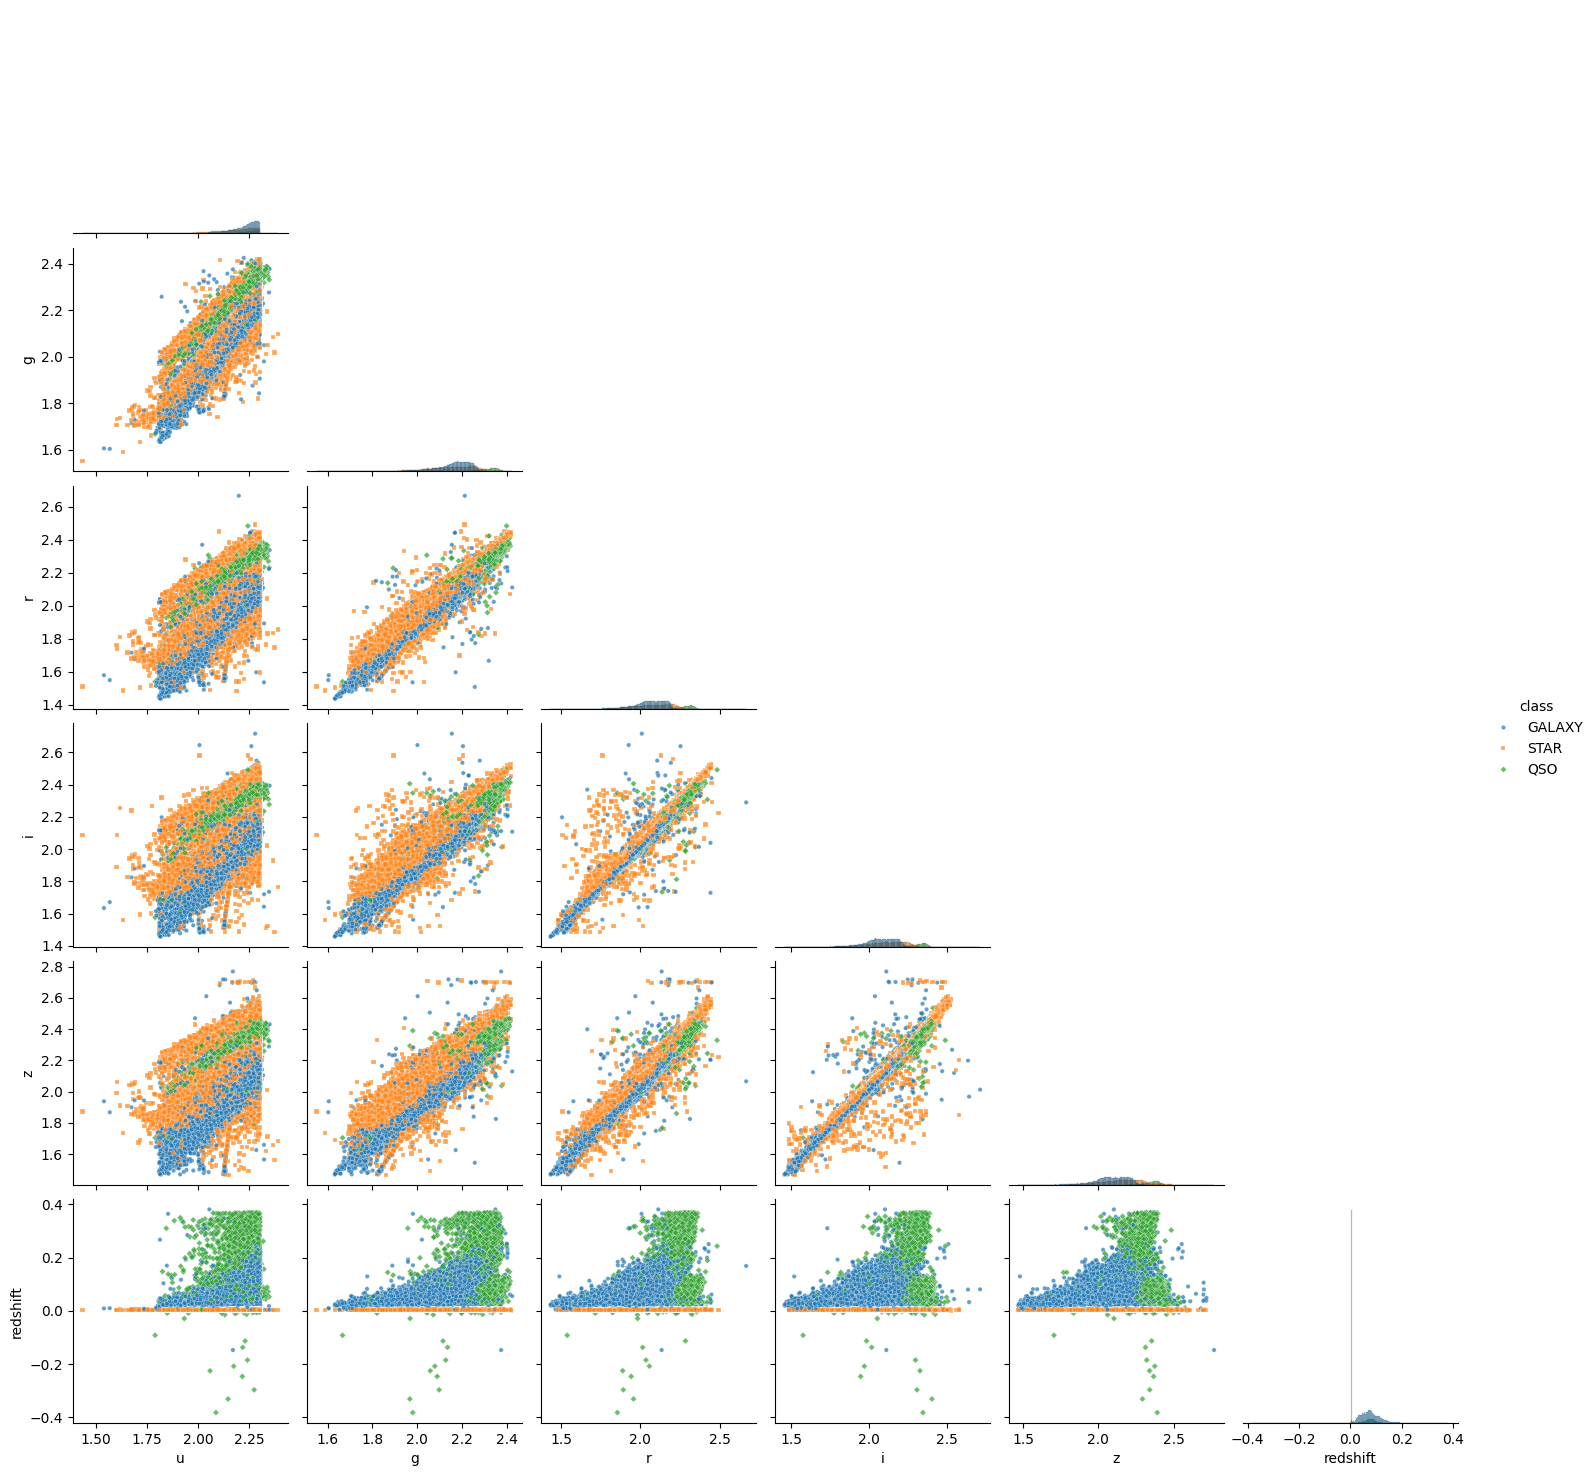

In [48]:
# - Draw scatter plot
sns.pairplot(df_clean_step4, vars=cols, hue="class", 
             markers=["o", "s", "D"], corner=True, diag_kind="hist", plot_kws={"s": 10, "alpha": 0.7}, dropna=False)

Let's make a UMAP 2D plot of the final cleaned data.

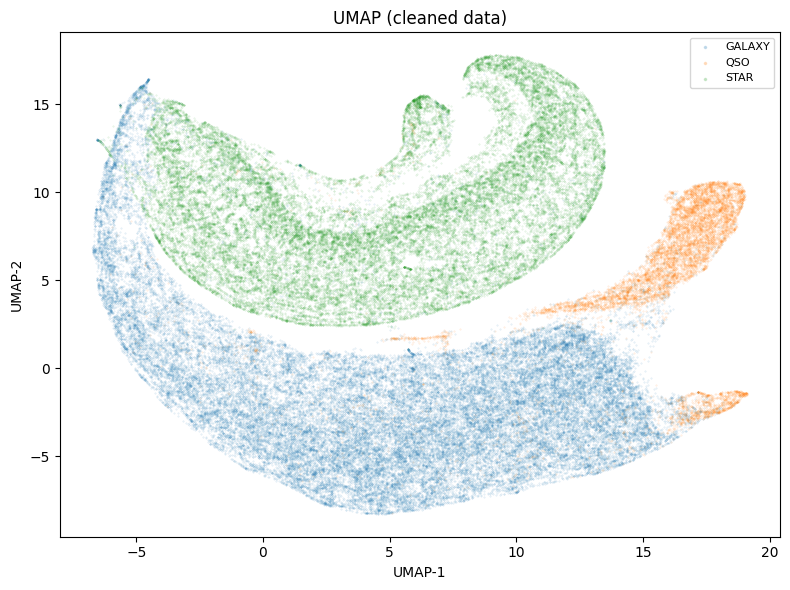

In [49]:
# - Set data for UMAP
X_clean_step4= df_clean_step4[cols]
y_clean_step4= df_clean_step4["class"]

# - Scale data before UMAP (new scaler as we removed outlier data)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_clean_step4)

# - Run UMAP & plot embeddings
X_clean_step4_embed= umap.fit_transform(X_scaled)

plot_embeddings(
  X_clean_step4_embed, 
  y_clean_step4, 
  mask=None, 
  title="UMAP (cleaned data)",
  s_normal=0.1,
  s_masked=0.1,
  alpha_normal=0.2,
  alpha_masked=0.2  
)